Initialized ForexPredictor with 1 forexcurrencies
Training period: 2008-08-01 to 2022-07-31
Testing period: 2022-08-01 to 2024-08-01
Fetching and preparing data...

Fetching forex data from 2008-08-01 00:00:00 to 2024-08-01 00:00:00
Loaded columns: ['open', 'high', 'low', 'close', 'volume', 'ecb_rate']
Data shape: (99210, 6)

Data Fetching Summary:
Successfully fetched data for 1 forex

Initial columns after loading:

EURUSD=X columns: ['open', 'high', 'low', 'close', 'volume', 'ecb_rate']

Processing EURUSD=X
Initial shape: (99210, 6)
Initial columns: ['open', 'high', 'low', 'close', 'volume', 'ecb_rate']
Added economic indicators: ['econ_inflation', 'econ_yield_spread', 'econ_real_rate', 'econ_fed_rate', 'econ_treasury_yield', 'econ_gdp', 'econ_inflation_change', 'econ_inflation_ma', 'econ_yield_spread_change', 'econ_yield_spread_ma', 'econ_real_rate_change', 'econ_real_rate_ma', 'econ_fed_rate_change', 'econ_fed_rate_ma', 'econ_treasury_yield_change', 'econ_treasury_yield_ma', 'econ

<Figure size 800x600 with 0 Axes>

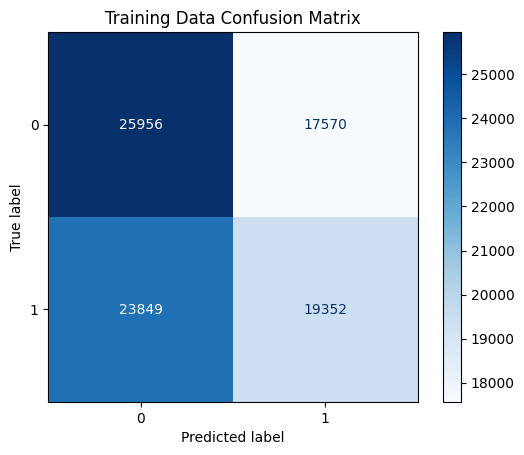


Feature list used for training: ['open', 'high', 'low', 'close', 'volume', 'ecb_rate', 'hourly_return', 'log_return', 'volatility', 'momentum_7d', 'momentum_14d', 'momentum_30d', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'asian_session', 'london_session', 'ny_session', 'positive_return', 'negative_return', 'up_volatility', 'down_volatility', 'up_momentum_24', 'down_momentum_24', 'up_momentum_120', 'down_momentum_120', 'up_momentum_480', 'down_momentum_480', 'rsi_6_gain', 'rsi_6_loss', 'rsi_14_gain', 'rsi_14_loss', 'rsi_24_gain', 'rsi_24_loss', 'macd', 'signal', 'hist', 'macd_up', 'macd_down', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_upper_distance', 'bb_lower_distance', 'mean_reversion_pressure', 'up_mean_reversion', 'down_mean_reversion', 'higher_highs', 'lower_lows', 'price_acceleration', 'up_acceleration', 'down_acceleration', 'ema_12', 'ema_26', 'ema_50', 'ema_100', 'ema_200', 'volatility_breakout_up', 'volatility_breakout_down', 'econ_fed_rate', 'econ_fed_rate

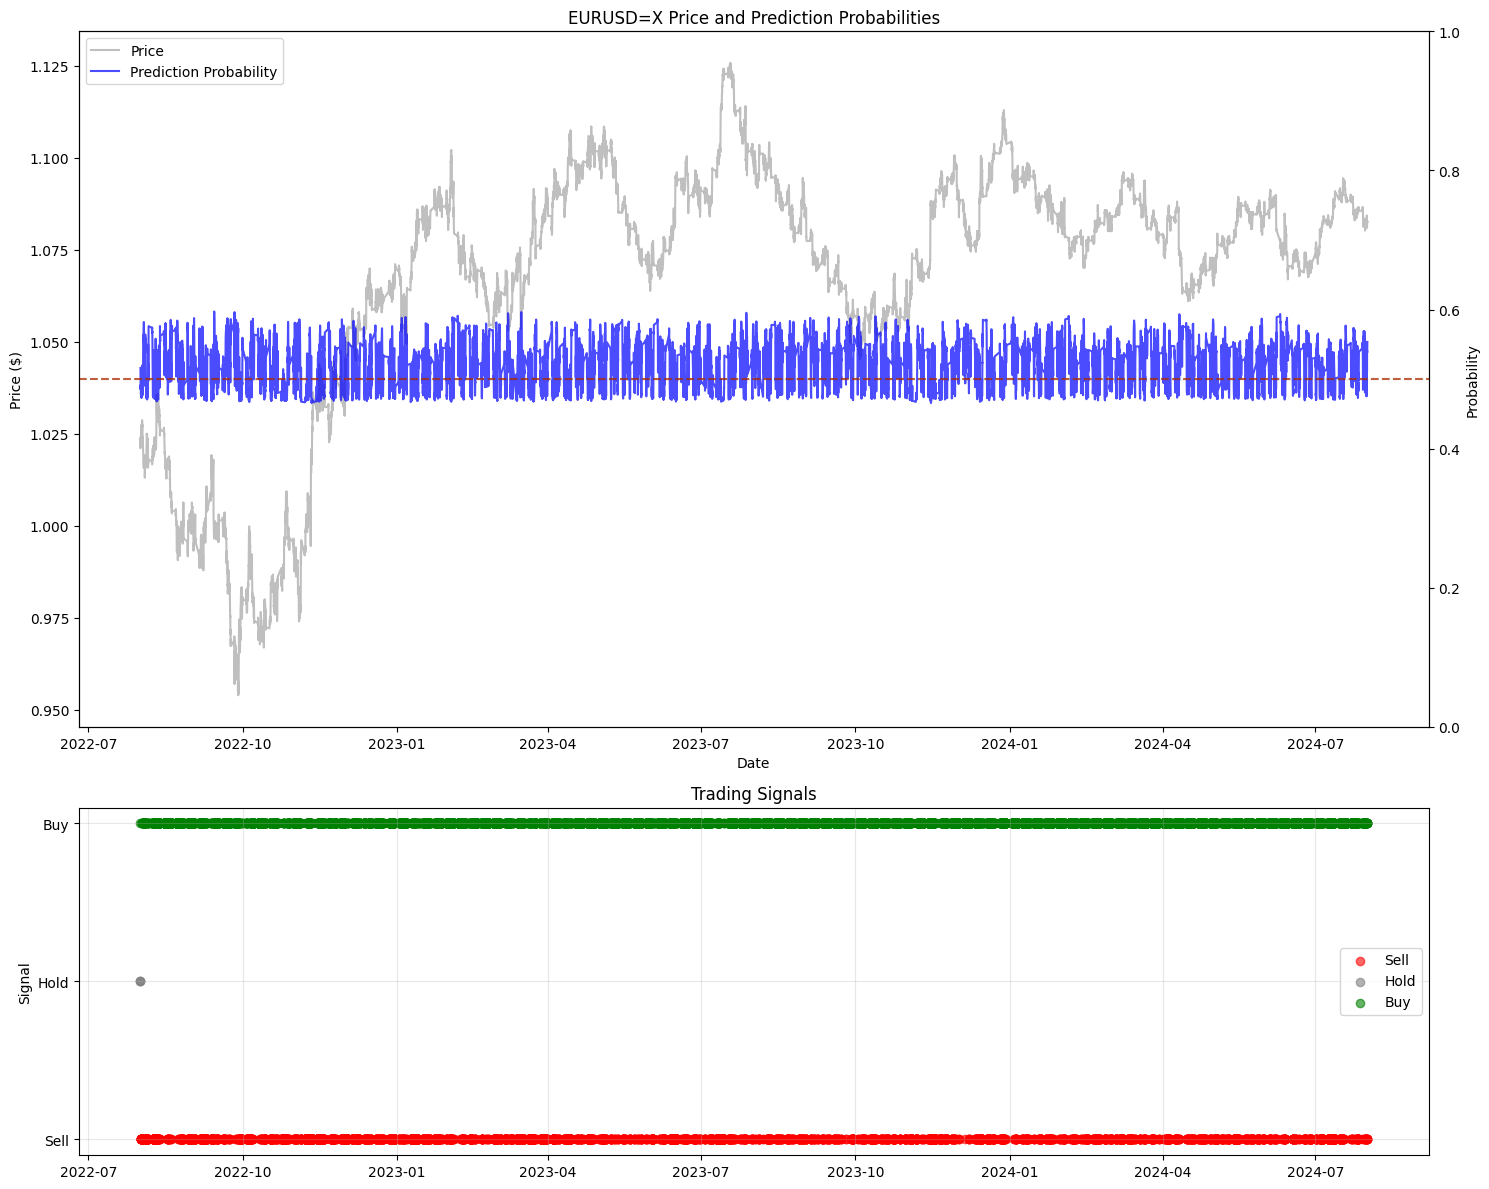

<Figure size 800x600 with 0 Axes>

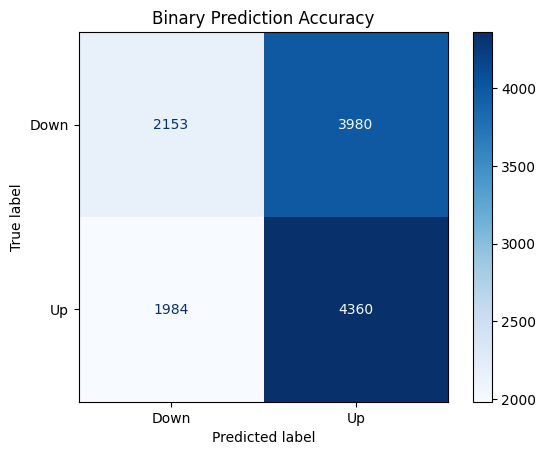


Binary Classification Report (probability > 0.5):
              precision    recall  f1-score   support

        Down       0.52      0.35      0.42      6133
          Up       0.52      0.69      0.59      6344

    accuracy                           0.52     12477
   macro avg       0.52      0.52      0.51     12477
weighted avg       0.52      0.52      0.51     12477


Trading Signal Distribution:
Buy: 8340 (66.8%)
Sell: 4137 (33.1%)
Hold: 3 (0.0%)

Debug info for Trading Period:
Number of rows: 12477
NaN counts in key columns:
position: 0 NaN values
actual_return: 0 NaN values
close: 0 NaN values

Trading Period Performance Metrics:
Date Range: 2022-08-01 to 2024-07-31
Number of Trading Hours: 12477

Return Metrics:
Total Return: 12.68%
Market Return: 5.93%
Annualized Return: 5.96%
Market Annualized Return: 2.83%
Sharpe Ratio: 0.47
Maximum Drawdown: 7.09%

Trading Metrics:
Number of Completed 'Round' Trades: 1461
Average Hourly Return (before costs): 0.0021%
Average Hourly Retu

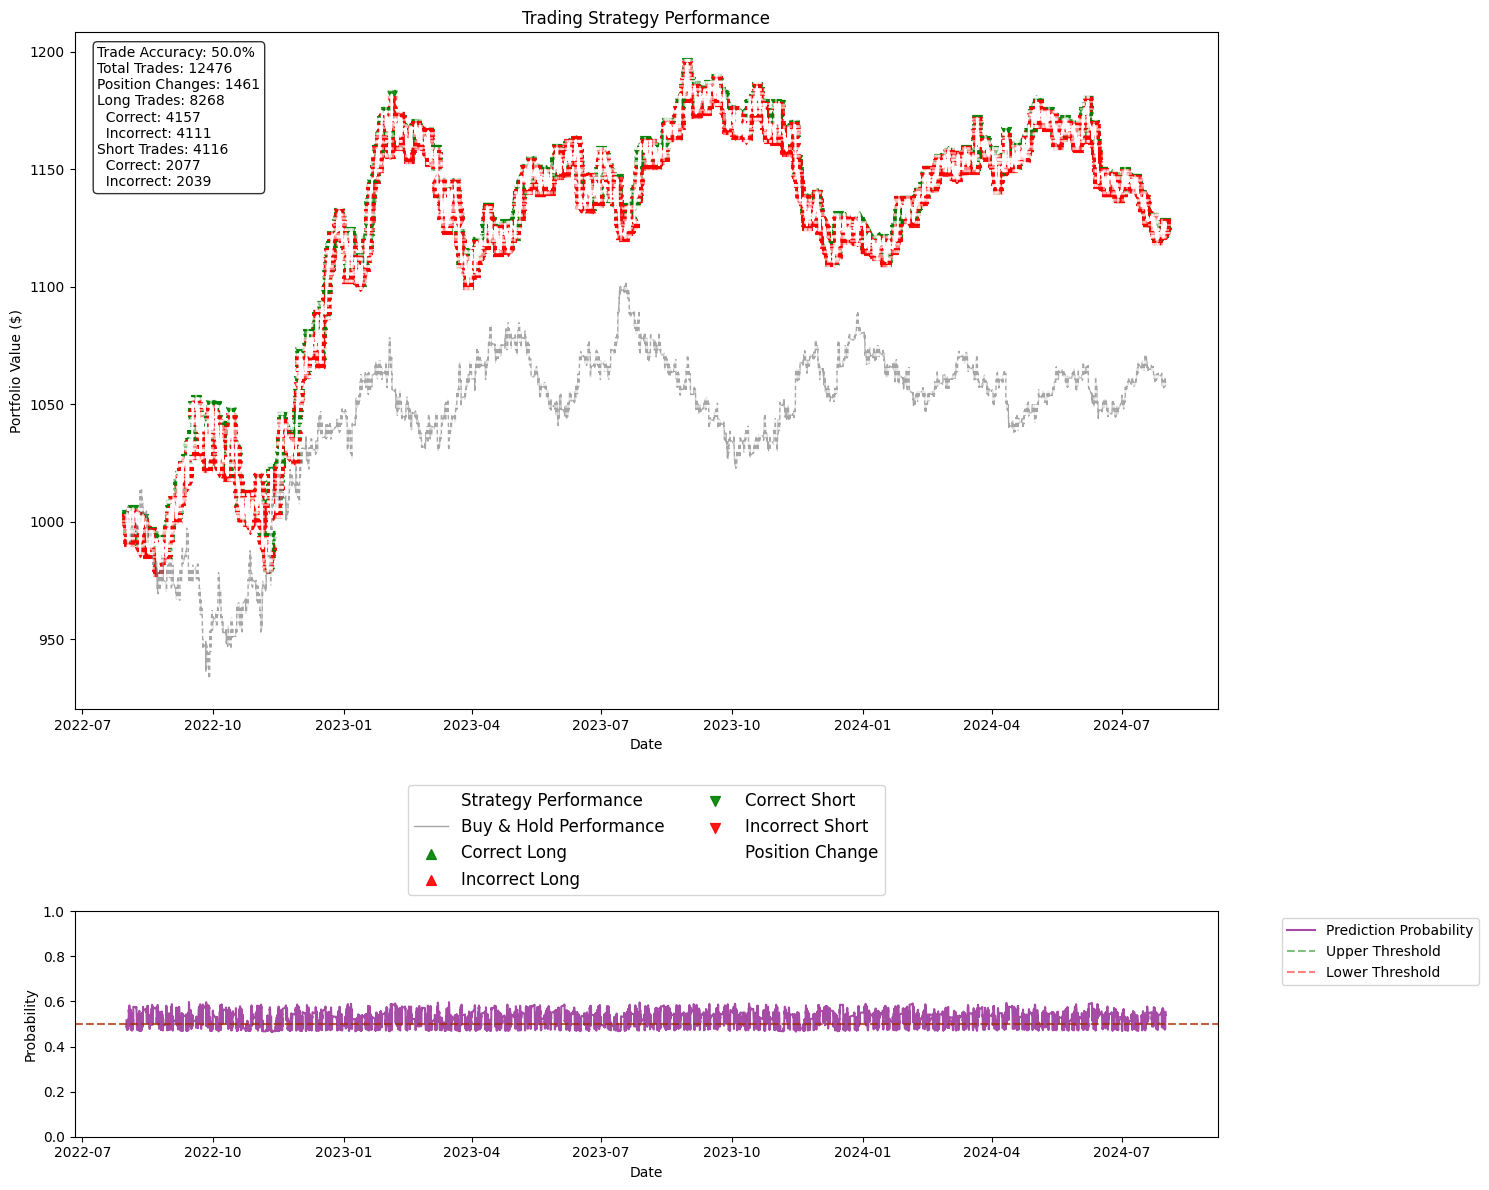


Analyzing feature importance...

Analyzing feature importance for EURUSD=X...


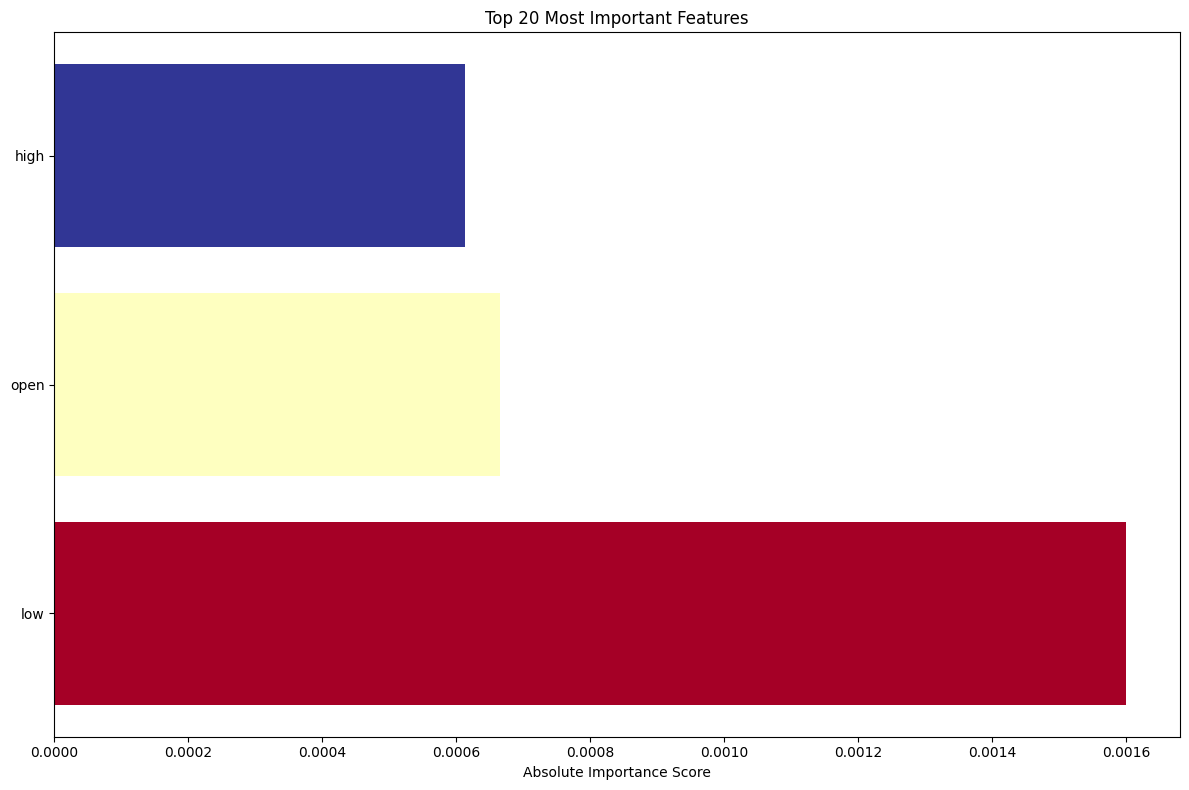


Feature Importance Statistics:

Top 10 Most Important Features:
low                            0.001600
open                           0.000665
high                           0.000612

Top 10 Features by Target Correlation:
momentum_14d                   0.030922
volatility_breakout_up         0.029010
up_momentum_24                 0.025483
momentum_30d                   0.025180
mean_reversion_pressure        0.024830
macd                           0.024474
volatility_breakout_down       0.024464
down_mean_reversion            0.024106
higher_highs                   0.023999
hour_cos                       0.023709


In [1]:
#########################################################################################################################

# 0. Import packages

#########################################################################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow import keras
from tensorflow.keras import backend as K
import yfinance as yf
import talib
import warnings
import requests
import time
warnings.filterwarnings('ignore')
import gc
import random 
import os
import pickle


#########################################################################################################################

# 1. Configuration setup

#########################################################################################################################

CONFIG = {
    'paths': {
        'forex_data': 'path/to/your/data/folder/file'             # '..../EURUSD_H1_200806301600_202408232300date_format.csv',
        #'fed_funds_data':                                        # Not used as economic indicators csv includes this data as well. Still kept it for flexibility reasons.  
        'ecb_rate_data': 'path/to/your/data/folder/file'          # '..../IC_Markets_data/ECB Data Portal_20241228020814.csv',
        'economic_indicators': 'path/to/your/data/folder/file'    # '..../Alpha_Vantage_econ_data_features.csv',  
        'model_save_path': 'path/to/your/folder'                  #  where you want to save the trained model
    },
    'random_seed': 12  # User-defined random seed
}


#########################################################################################################################

# 2. Data prep, feature engineering, model build, evaluation

#########################################################################################################################


class ForexPredictor:
    """Forex (EURUSD) high-frequency trading model based on Transformers aiming to predict the direction of price change."""
    
    def __init__(self, csv_path, tickers, train_start_date, train_end_date, 
                 test_start_date, test_end_date, random_seed=12):
      
        # Set random seed for reproducibility
        self.random_seed = random_seed
        np.random.seed(self.random_seed)
        tf.random.set_seed(self.random_seed)
        random.seed(self.random_seed)
        
        # Ensure determinism for TensorFlow
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['PYTHONHASHSEED'] = str(self.random_seed)
        
        # Limit TensorFlow's thread usage
        tf.config.threading.set_intra_op_parallelism_threads(1)
        tf.config.threading.set_inter_op_parallelism_threads(1)
        
        # For GPU operations (if using GPU)
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            try:
                for device in physical_devices:
                    tf.config.experimental.set_memory_growth(device, True)
            except:
                print("Memory growth setting failed")

        # Initialize params
        self.csv_path = CONFIG['paths']['forex_data']
        #self.fed_funds_path = CONFIG['paths']['fed_funds_data']  # Not used as economic indicators' csv includes this data as well. Still kept it for flexibility reasons.  
        self.ecb_rate_path = CONFIG['paths']['ecb_rate_data']
        self.economic_indicators_path = CONFIG['paths']['economic_indicators']
        self.model_save_path = CONFIG['paths']['model_save_path']
        self.csv_path = csv_path
        self.tickers = tickers
        self.train_start_date = train_start_date
        self.train_end_date = train_end_date
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date
        
        # Initialize data containers
        self.data = {}
        self.combined_data = None
        self.model = None
        self.economic_data = None
        self.market_data = None
        self.spx_data = None
        self.initial_prices = {}
               
        print(f"Initialized ForexPredictor with {len(tickers)} forexcurrencies")
        print(f"Training period: {train_start_date} to {train_end_date}")
        print(f"Testing period: {test_start_date} to {test_end_date}")

        
    def save_model(self):
        """Save the trained model and necessary components"""
        if self.model is None:
            raise ValueError("No trained model to save. Please train the model first.")

        if self.window_size is None:
            raise ValueError("Window size not set. Please train the model first.")

        try:
            # Create a directory for the model if it doesn't exist
            import os
            model_dir = os.path.dirname(self.model_save_path)
            if model_dir and not os.path.exists(model_dir):
                os.makedirs(model_dir)

            # Save model weights separately
            weights_path = self.model_save_path + '_weights.h5'
            self.model.save_weights(weights_path)
            print(f"Model weights saved to {weights_path}")

            # Save model architecture as JSON
            model_json = self.model.to_json()
            architecture_path = self.model_save_path + '_architecture.json'
            with open(architecture_path, 'w') as f:
                f.write(model_json)
            print(f"Model architecture saved to {architecture_path}")

            # Save additional components using pickle
            import pickle
            components = {
                'window_size': self.window_size,
                'scaler': self.scaler,
                'feature_list': self.feature_list,
            }

            # Save components to a separate file
            components_file = self.model_save_path + '.pkl'
            with open(components_file, 'wb') as f:
                pickle.dump(components, f)
            print(f"Model components saved to {components_file}")

            # Save model configuration
            config = {
                'train_start_date': self.train_start_date,
                'train_end_date': self.train_end_date,
                'test_start_date': self.test_start_date,
                'test_end_date': self.test_end_date,
                'tickers': self.tickers,
            }

            # Save configuration to a separate file
            config_file = self.model_save_path + '.config.pkl'
            with open(config_file, 'wb') as f:
                pickle.dump(config, f)
            print(f"Model configuration saved to {config_file}")

            print("\nSaved Model Summary:")
            print(f"Model weights: {weights_path}")
            print(f"Model architecture: {architecture_path}")
            print(f"Components saved: {', '.join(components.keys())}")
            print(f"Configuration saved: {', '.join(config.keys())}")

            return True

        except Exception as e:
            print(f"Error saving model: {str(e)}")
            return False


        
    # Convert date to timezone naive format
    def _convert_to_timezone_naive(self, df):
        """Convert DataFrame index to timezone naive"""
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)
        return df



    def fetch_forex_data(self):
        """Fetch EURUSD hourly data using the csv files"""
        self.initial_prices = {}
        failed_tickers = []

        start_date = pd.to_datetime(min(self.train_start_date, self.test_start_date))
        end_date = pd.to_datetime(max(self.train_end_date, self.test_end_date))

        print(f"\nFetching forex data from {start_date} to {end_date}")

        for ticker in self.tickers:
            try:
                # Read the main forex CSV file
                df = pd.read_csv(self.csv_path)

                # Read the Fed funds rate CSV
#                 fed_data = pd.read_csv('C:/Users/balaz/Documents/IC_Markets_data/FEDFUNDS.csv')
#                 fed_data['observation_date'] = pd.to_datetime(fed_data['observation_date'])
#                 fed_data.set_index('observation_date', inplace=True)

                # Read the ECB rate CSV
                ecb_data = pd.read_csv(self.ecb_rate_path)  
                
                # Convert DATE and format TIME_PERIOD to datetime
                ecb_data['DATE'] = pd.to_datetime(ecb_data['DATE'])
                ecb_data['ECB_rate'] = ecb_data['ECB_rate'].astype(float)  # Ensure rate is numeric
                ecb_data.set_index('DATE', inplace=True)

                # Combine date and time columns and set as index for main data
                df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
                df.set_index('datetime', inplace=True)

                # Drop original date and time columns
                df = df.drop(['date', 'time'], axis=1)

                # Standardize column names to lowercase
                df.columns = df.columns.str.lower()

#                 # Resample Fed funds rate to hourly frequency and forward fill
#                 hourly_fed_rate = fed_data.reindex(df.index, method='ffill')
#                 df['fed_funds_rate'] = hourly_fed_rate['FEDFUNDS']

                # Resample ECB rate to hourly frequency and forward fill
                hourly_ecb_rate = ecb_data.reindex(df.index, method='ffill')
                df['ecb_rate'] = hourly_ecb_rate['ECB_rate']
                

                # Filter data between start_date and end_date
                mask = (df.index >= start_date) & (df.index <= end_date)
                df = df[mask]

                if not df.empty:
                    # Store the data
                    self.data = {'EURUSD=X': df}
                    self.initial_prices['EURUSD=X'] = df['close'].iloc[0]

                    print(f"Loaded columns: {df.columns.tolist()}")
                    print(f"Data shape: {df.shape}")
                else:
                    print("No data available for the specified date range")

            except Exception as e:
                print(f"Error loading CSV data: {str(e)}")

                # Some prints about the data shape:
                print(f"\nDownloaded columns for {ticker}:", data.columns.tolist())
                print(f"Data shape before processing: {data.shape}")
                
                # Inside fetch_forex_data method, modify the data processing part:
                if data.empty:
                    print(f"No data received for {ticker}")
                    failed_tickers.append(ticker)
                    continue

                # Store initial price using regular close price
                self.initial_prices[ticker] = data['Close'].iloc[0]


                # Apply column mapping
                column_mapping = {
                    'Close': 'close',
                    'Open': 'open',
                    'High': 'high',
                    'Low': 'low',
                    'Volume': 'volume'
                }
                data.columns = [column_mapping.get(col, col.lower()) for col in data.columns]

                self.data[ticker] = data

                print(f"Successfully fetched data for {ticker}")
                print(f"Shape: {data.shape}")
                print(f"Date range: {data.index.min()} to {data.index.max()}")
                print(f"Columns: {data.columns.tolist()}")

            except Exception as e:
                print(f"Error fetching data for {ticker}: {str(e)}")
                failed_tickers.append(ticker)
                continue

             
        # Final status report
        print("\nData Fetching Summary:")
        print(f"Successfully fetched data for {len(self.data)} forex")
        if failed_tickers:
            print(f"Failed to fetch data for {len(failed_tickers)} forex: {failed_tickers}")

        # Verify data availability
        if not self.data:
            raise ValueError("No forex data was successfully fetched")
        
        print("\nInitial columns after loading:")
        for ticker, df in predictor.data.items():
            print(f"\n{ticker} columns:", df.columns.tolist())

        return self.data
    
    
    def load_economic_indicators(self, df):
        """Load and process additional economic indicators"""
        try:
            # Read economic indicators
            econ_data = pd.read_csv(self.economic_indicators_path)
            econ_data['datetime'] = pd.to_datetime(econ_data['datetime'])
            econ_data.set_index('datetime', inplace=True)

            # Resample to hourly frequency and forward fill
            econ_data = econ_data.resample('1H').ffill()

            # Merge with main dataframe
            df = df.join(econ_data, how='left')

            # Calculate changes and differences
            for col in ['econ_inflation', 'econ_yield_spread', 'econ_real_rate', 
                       'econ_fed_rate', 'econ_treasury_yield', 'econ_gdp']:
                if col in df.columns:
                    df[f'{col}_change'] = df[col].diff()
                    df[f'{col}_ma'] = df[col].rolling(window=24).mean()  # 24-hour moving average

            # Handle NaN values
            df = df.fillna(method='ffill')

            print(f"Added economic indicators: {[col for col in df.columns if 'econ_' in col]}")
            return df
        except Exception as e:
            print(f"Error loading economic indicators: {str(e)}")
            return df


    def add_technical_indicators(self, df):
        """Add technical indicators for EURUSD trading."""
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Ensure correct data types
        for col in ['open', 'high', 'low', 'close', 'volume']:
            if col in df.columns:
                df[col] = df[col].astype(float)

        try:
            # Add basic forex-specific metrics
            df['hourly_return'] = df['close'].pct_change()
            df['log_return'] = np.log(df['close'] / df['close'].shift(1))
            df['volatility'] = df['hourly_return'].rolling(window=10).std()

            # Add price momentum indicators
            for period in [7, 14, 30]:
                df[f'momentum_{period}d'] = df['close'].pct_change(periods=period)
                
            # Handle any NaN values
            df = df.fillna(method='ffill').fillna(method='bfill')
            
            # Add time-based features
            df['hour'] = df.index.hour
            df['day_of_week'] = df.index.dayofweek

            # Cyclical transformations for time features
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

            # Session indicators for major Forex sessions
            df['asian_session'] = ((df['hour'] >= 0) & (df['hour'] < 8)).astype(int)
            df['london_session'] = ((df['hour'] >= 8) & (df['hour'] < 16)).astype(int)
            df['ny_session'] = ((df['hour'] >= 13) & (df['hour'] < 21)).astype(int)

            # Price-based indicators
#             df['log_price'] = np.log(df['close']).rolling(window=1).mean()
#             df['log_return_'] = df['log_price'].diff().rolling(window=1).mean()

            # Separate positive and negative returns
            df['positive_return'] = df['log_return'].clip(lower=0).rolling(window=6).mean()
            df['negative_return'] = df['log_return'].clip(upper=0).rolling(window=6).mean()

            # Directional volatility
            df['up_volatility'] = df['positive_return'].rolling(window=6).std() * np.sqrt(252)
            df['down_volatility'] = df['negative_return'].rolling(window=6).std() * np.sqrt(252)
            
            # Drop hour and day of week columns
            df = df.drop(['hour', 'day_of_week'], axis=1)

            # Momentum indicators with directional components
            momentum_periods = [24, 120, 480]  # 1d, 1w, 1m
            for period in momentum_periods:
                returns = df['close'].pct_change(periods=period)
                returns_name = f'up_momentum_{period}'
                df[returns_name] = pd.Series(returns.clip(lower=0), index=df.index).rolling(window=1).mean()
                df[f'down_momentum_{period}'] = pd.Series(returns.clip(upper=0), index=df.index).rolling(window=1).mean()

            # Directional RSI components
            rsi_periods = [6, 14, 24]
            for period in rsi_periods:
                delta = df['close'].diff()
                gain = delta.clip(lower=0).rolling(window=period).mean()
                loss = -delta.clip(upper=0).rolling(window=period).mean()
                df[f'rsi_{period}_gain'] = gain
                df[f'rsi_{period}_loss'] = loss

            # MACD with directional components
            macd, signal, hist = talib.MACD(df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
            df['macd'] = pd.Series(macd, index=df.index)
            df['signal'] = pd.Series(signal, index=df.index)
            df['hist'] = pd.Series(hist, index=df.index)
            df['macd_up'] = df['hist'].clip(lower=0).rolling(window=1).mean()
            df['macd_down'] = df['hist'].clip(upper=0).rolling(window=1).mean()

            # Bollinger Bands with directional pressure
            bb_upper, bb_middle, bb_lower = talib.BBANDS(
                df['close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0
            )
            df['bb_upper'] = pd.Series(bb_upper, index=df.index)
            df['bb_middle'] = pd.Series(bb_middle, index=df.index)
            df['bb_lower'] = pd.Series(bb_lower, index=df.index)

            # Distance from BB bands
            df['bb_upper_distance'] = ((df['close'] - df['bb_upper']) / df['bb_middle']).rolling(window=6).mean()
            df['bb_lower_distance'] = ((df['close'] - df['bb_lower']) / df['bb_middle']).rolling(window=6).mean()

            # Mean reversion components
            df['mean_reversion_pressure'] = ((df['close'] - df['bb_middle']) / df['bb_middle']).rolling(window=6).mean()
            df['up_mean_reversion'] = df['mean_reversion_pressure'].clip(upper=0) * -1
            df['down_mean_reversion'] = df['mean_reversion_pressure'].clip(lower=0)

            # Directional volume pressure
#             if 'volume' in df.columns:
#                 df['up_volume'] = df['volume'].where(df['close'] > df['close'].shift(1), 0).rolling(window=6).mean()
#                 df['down_volume'] = df['volume'].where(df['close'] < df['close'].shift(1), 0).rolling(window=6).mean()
#                 # On-Balance Volume
#                 df['obv'] = pd.Series(talib.OBV(df['close'].values, df['volume'].values), index=df.index)
#                 df['obv_ma'] = df['obv'].rolling(window=1).mean()

            # Price patterns
            df['higher_highs'] = (df['high'] > df['high'].shift(1)).rolling(window=6).sum()
            df['lower_lows'] = (df['low'] < df['low'].shift(1)).rolling(window=6).sum()

            # Price acceleration
            df['price_acceleration'] = df['log_return'].diff().rolling(window=6).mean()
            df['up_acceleration'] = df['price_acceleration'].clip(lower=0)
            df['down_acceleration'] = df['price_acceleration'].clip(upper=0)

            # Trend strength indicators
#             adx = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
#             plus_di = talib.PLUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
#             minus_di = talib.MINUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
#             df['adx'] = pd.Series(adx, index=df.index).rolling(window=1).mean()
#             df['trend_strength_up'] = pd.Series(plus_di, index=df.index).rolling(window=1).mean()
#             df['trend_strength_down'] = pd.Series(minus_di, index=df.index).rolling(window=1).mean()

            # Pivot Points
#             pivot = (df['high'] + df['low'] + df['close']) / 3
#             df['pivot'] = pivot.rolling(window=1).mean()
#             df['r1'] = (2 * df['pivot'] - df['low']).rolling(window=6).mean()
#             df['s1'] = (2 * df['pivot'] - df['high']).rolling(window=6).mean()
#             df['r2'] = (df['pivot'] + (df['high'] - df['low'])).rolling(window=6).mean()
#             df['s2'] = (df['pivot'] - (df['high'] - df['low'])).rolling(window=6).mean()

            # Manual Implementation of Ichimoku Cloud
            # Tenkan-sen (Conversion Line)
#             period9_high = df['high'].rolling(window=9).max()
#             period9_low = df['low'].rolling(window=9).min()
#             df['tenkan_sen'] = ((period9_high + period9_low) / 2).rolling(window=1).mean()

#             # Kijun-sen (Base Line)
#             period26_high = df['high'].rolling(window=26).max()
#             period26_low = df['low'].rolling(window=26).min()
#             df['kijun_sen'] = ((period26_high + period26_low) / 2).rolling(window=1).mean()

#             # Senkou Span A (Leading Span A)
#             df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26).rolling(window=1).mean()

#             # Senkou Span B (Leading Span B)
#             period52_high = df['high'].rolling(window=52).max()
#             period52_low = df['low'].rolling(window=52).min()
#             df['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26).rolling(window=1).mean()

#             # ATR for volatility
#             atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
#             df['atr'] = pd.Series(atr, index=df.index).rolling(window=1).mean()

            # Stochastic Oscillator
#             slowk, slowd = talib.STOCH(
#                 df['high'].values,
#                 df['low'].values,
#                 df['close'].values,
#                 fastk_period=14,
#                 slowk_period=3,
#                 slowk_matype=0,
#                 slowd_period=3,
#                 slowd_matype=0
#             )
#             df['slowk'] = pd.Series(slowk, index=df.index).rolling(window=6).mean()
#             df['slowd'] = pd.Series(slowd, index=df.index).rolling(window=6).mean()

            # Currency-specific strength indicators
#             roc = talib.ROC(df['close'].values, timeperiod=10)
#             df['price_rate_of_change'] = pd.Series(roc, index=df.index).rolling(window=6).mean()
#             df['normalized_range'] = ((df['high'] - df['low']) / df['close']).rolling(window=6).mean()

            # Exponential Moving Averages
            ema_periods = [12, 26, 50, 100, 200]
            for ema in ema_periods:
                ema_values = talib.EMA(df['close'].values, timeperiod=ema)
                df[f'ema_{ema}'] = pd.Series(ema_values, index=df.index).rolling(window=1).mean()

            # On-Balance Volume 
#             if 'volume' in df.columns:
#                 obv = talib.OBV(df['close'].values, df['volume'].values)
#                 df['obv'] = pd.Series(obv, index=df.index)
#                 df['obv_ma'] = df['obv'].rolling(window=1).mean()

            # SuperTrend Indicator (Manual Implementation)
#             def calculate_supertrend(df, period=10, multiplier=3):
#                 hl2 = (df['high'] + df['low']) / 2
#                 atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
#                 atr = pd.Series(atr, index=df.index)
#                 up = hl2 + (multiplier * atr)
#                 down = hl2 - (multiplier * atr)

#                 supertrend = pd.Series(np.nan, index=df.index)
#                 trend = True  # True means uptrend

#                 for i in range(1, len(df)):
#                     if pd.isna(up.iloc[i - 1]) or pd.isna(down.iloc[i - 1]):
#                         continue

#                     if df['close'].iloc[i] > up.iloc[i - 1]:
#                         trend = True
#                     elif df['close'].iloc[i] < down.iloc[i - 1]:
#                         trend = False

#                     if trend:
#                         supertrend.iloc[i] = down.iloc[i]
#                     else:
#                         supertrend.iloc[i] = up.iloc[i]

#                 # Rolling window on SuperTrend
#                 supertrend = supertrend.rolling(window=1).mean()
#                 return supertrend

#             df['supertrend'] = calculate_supertrend(df).rolling(window=1).mean()

            # Expanded Candlestick Patterns
#             df['doji'] = talib.CDLDOJI(df['open'], df['high'], df['low'], df['close'])
#             df['hammer'] = talib.CDLHAMMER(df['open'], df['high'], df['low'], df['close'])
#             df['engulfing_bullish'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])
#             df['engulfing_bearish'] = talib.CDLENGULFING(
#                 df['open'].shift(1),
#                 df['high'].shift(1),
#                 df['low'].shift(1),
#                 df['close'].shift(1)
#             )
#             # Convert to binary features
#             df['doji'] = (df['doji'] != 0).astype(int).rolling(window=1).max()
#             df['hammer'] = (df['hammer'] != 0).astype(int).rolling(window=1).max()
#             df['engulfing_bullish'] = (df['engulfing_bullish'] > 0).astype(int)
#             df['engulfing_bearish'] = (df['engulfing_bearish'] < 0).astype(int)

            # Volatility breakout indicators
            df['volatility_breakout_up'] = (
                ((df['close'] - df['close'].rolling(window=6).mean()) / df['close'].rolling(window=6).std())
                .clip(lower=0)
                .rolling(window=6)
                .mean()
            )
            df['volatility_breakout_down'] = (
                ((df['close'] - df['close'].rolling(window=6).mean()) / df['close'].rolling(window=6).std())
                .clip(upper=0)
                .rolling(window=6)
                .mean()
            )
            
            # Add economic indicators
            df = self.load_economic_indicators(df)

            # Replace infinite values with NaN
            df.replace([np.inf, -np.inf], np.nan, inplace=True)

            # Forward fill and backward fill NaN values
            df.fillna(method='ffill', inplace=True)
            df.fillna(method='bfill', inplace=True)

#             # Add Fed funds rate change as additional feature
#             df['fed_funds_rate_change'] = df['fed_funds_rate'].diff()

#             # Handle any NaN values in the new features
#             df['fed_funds_rate'] = df['fed_funds_rate'].fillna(method='ffill')
#             df['fed_funds_rate_change'] = df['fed_funds_rate_change'].fillna(0)

            # Add ECB rate change as additional feature
            df['ecb_rate_change'] = df['ecb_rate'].diff()

            # Handle any NaN values in the new features
            df['ecb_rate'] = df['ecb_rate'].fillna(method='ffill')
            df['ecb_rate_change'] = df['ecb_rate_change'].fillna(0)

            # Calculate the rate differential 
            df['rate_differential'] = df['econ_fed_rate'] - df['ecb_rate']
            
            df.drop(['econ_yield_spread_ma','econ_treasury_yield_ma', 'econ_gdp_change', 
                'econ_gdp_ma','econ_gdp','econ_yield_spread','econ_yield_spread_change', 
                'econ_yield_spread_ma','econ_fed_rate_ma','econ_treasury_yield_ma',
                'econ_inflation_ma',
                'econ_inflation', 'econ_real_rate', 'econ_treasury_yield', 
                'econ_inflation_change', 'econ_real_rate_change', 'econ_real_rate_ma', 
                'econ_treasury_yield_change', 'ecb_rate_change', ], axis=1, inplace=True)
            
            print(f"Added {len(df.columns)} technical indicators")
            return df

        except Exception as e:
            print(f"Error adding technical indicators: {str(e)}")
            print(f"Current columns: {df.columns.tolist()}")
            raise e

        
        return features_to_use

    def prepare_data(self, window_size=3, future_period=3):
        """Prepare forex data with proper target shifting and feature matching."""
        if not self.data:
            raise ValueError("No data available. Please fetch data first.")
                
        for ticker, data in self.data.items():
            # Resample to ensure consistent hourly intervals
            data = data.resample('1H').ffill()

            # Handle after-hours and weekend gaps
            data = data.fillna(method='ffill')

        all_data = []
        for ticker, df in self.data.items():
            try:
                print(f"\nProcessing {ticker}")
                if df.empty:
                    print(f"Skipping {ticker} - no data available")
                    continue

                processed_df = df.copy()
                processed_df = processed_df.replace([np.inf, -np.inf], np.nan)

                print(f"Initial shape: {processed_df.shape}")
                print(f"Initial columns: {processed_df.columns.tolist()}")

                # Add technical indicators
                processed_df = self.add_technical_indicators(processed_df)
                print("Added technical indicators")


                # Create target variable
                if 'close' in processed_df.columns:
                    transaction_cost = 0    # For now the training is without transaction cost, but during evaluation trasaction cost is applied. 
                    volatility_window = 3  # For now the training is without volatility scaling, but it can be set here for experimentation purposes.
                    volatility_scaling = 1.0  # For now the training is without volatility scaling, but it can be set here for experimentation purposes.

                    # Calculate average log returns
                    returns_list = []
                    for i in range(1, future_period + 1):
                        future_price_i = processed_df['close'].shift(-i)
                        prev_price_i = processed_df['close'].shift(-(i-1))
                        hourly_return_i = np.log(future_price_i / prev_price_i)
                        returns_list.append(hourly_return_i)

                    stacked_returns = pd.concat(returns_list, axis=1)
                    avg_log_return = stacked_returns.mean(axis=1)
                    avg_log_return = avg_log_return.replace([np.inf, -np.inf], np.nan)

                    # Calculate rolling volatility of log returns
                    hourly_log_returns = np.log(processed_df['close'] / processed_df['close'].shift(1))
                    rolling_vol = hourly_log_returns.rolling(window=volatility_window).std()

                    # Calculate dynamic threshold
                    base_threshold = -np.log(1 - transaction_cost) * 2  # Base threshold from transaction costs
                    dynamic_threshold = base_threshold # + (rolling_vol * volatility_scaling)  For now the training is without volatility scaling, but it can be set here for experimentation purposes.


                    conditions = [
                        (avg_log_return > dynamic_threshold),      # Long position
                        (avg_log_return < -dynamic_threshold)      # Short position
                    ]
                    choices = [1, 0]    # Need to assess if appropriate dynamic threshold usage would actually require three classes. Something to consider later. 
                    
                    processed_df['target'] = np.select(conditions, choices)


                    print(f"Created target variable with {future_period} period(s) shift.")
                else:
                    print(f"Warning: close price not found in columns: {processed_df.columns}")
                    continue


                # Add ticker column and handle NaN values
                processed_df['ticker'] = ticker
                original_rows = len(processed_df)
                processed_df = processed_df.dropna(subset=['target'])
                print(f"Dropped {original_rows - len(processed_df)} rows with NaN targets")


                # Final NaN check and handling
                if processed_df.isna().any().any():
                    nan_cols = processed_df.columns[processed_df.isna().any()].tolist()
                    print(f"Warning: NaN values found in columns: {nan_cols}")
                    processed_df = processed_df.fillna(method='ffill').fillna(method='bfill')

                # Verify we still have data
                if processed_df.empty:
                    print(f"No valid data remaining for {ticker} after processing")
                    continue

                print(f"Final shape: {processed_df.shape}")
                all_data.append(processed_df)
                print(f"Successfully processed {ticker}")

            except Exception as e:
                print(f"Error processing {ticker}: {e}")
                import traceback
                traceback.print_exc()
                continue

        # Rest of the method (combining data and splitting into train/test) 
        if not all_data:
            raise ValueError("No valid data available after processing")

        print("\nCombining all processed data...")
        try:
            self.combined_data = pd.concat(all_data)
            self.combined_data.sort_index(inplace=True)
            print(f"Combined data shape: {self.combined_data.shape}")
            print(f"Date range: {self.combined_data.index.min()} to {self.combined_data.index.max()}")
        except Exception as e:
            print(f"Error combining data: {e}")
            raise

                    
        try:
            print("\nSplitting data into training and testing sets...")

            # Convert index to timezone naive
            self.combined_data.index = self.combined_data.index.tz_localize(None)

            # Convert dates to timezone naive datetime
            train_start = pd.to_datetime(self.train_start_date).tz_localize(None)
            train_end = pd.to_datetime(self.train_end_date).tz_localize(None)
            test_start = pd.to_datetime(self.test_start_date).tz_localize(None)
            test_end = pd.to_datetime(self.test_end_date).tz_localize(None)

            mask_train = (
                (self.combined_data.index >= train_start) & 
                (self.combined_data.index <= train_end)
            )
            mask_test = (
                (self.combined_data.index >= test_start) & 
                (self.combined_data.index <= test_end)
            )

            self.training_data = self.combined_data[mask_train].copy()
            self.testing_data = self.combined_data[mask_test].copy()

        except Exception as e:
            print(f"Error splitting data: {e}")
            raise
            
            
            print("\nData Preparation Summary:")
            print(f"Training data shape: {self.training_data.shape}")
            print(f"Training period: {self.training_data.index.min()} to {self.training_data.index.max()}")
            print(f"Testing data shape: {self.testing_data.shape}")
            print(f"Testing period: {self.testing_data.index.min()} to {self.testing_data.index.max()}")

            # Print feature summary
            print("\nFeature Summary:")
            features = [col for col in self.combined_data.columns if col not in ['ticker', 'target']]
            print(f"Total number of features: {len(features)}")
            print("\nFeature categories:")
            print("- Price features:", [f for f in features if 'price' in f.lower()])
            print("- Volume features:", [f for f in features if 'volume' in f.lower()])
            print("- Volatility features:", [f for f in features if 'volatility' in f.lower()])
            print("- Market features:", [f for f in features if 'market' in f.lower()])
            print("- Economic features:", [f for f in features if any(x in f.lower() for x in ['gdp', 'fed', 'rate', 'econ'])])

        except Exception as e:
            print(f"Error splitting data: {e}")
            raise
            
            
        # Some checks
        print("\nData Preprocessing Check:")
        for col in predictor.combined_data.columns:
            # Check if column is numeric
            if predictor.combined_data[col].dtype.kind in 'biufc':  # numeric types
                non_finite = predictor.combined_data[col].isna() | \
                            (predictor.combined_data[col] == np.inf) | \
                            (predictor.combined_data[col] == -np.inf)
                n_bad = non_finite.sum()
                if n_bad > 0:
                    print(f"\nColumn '{col}' ({predictor.combined_data[col].dtype}) has {n_bad} non-finite values")
                    print("Sample of problematic rows:")
                    print(predictor.combined_data[non_finite][col].head())
            else:
                print(f"\nColumn '{col}' has non-numeric type: {predictor.combined_data[col].dtype}")

        # Additional checks before processing
        print("\nChecking for extreme values in numeric columns:")
        for col in predictor.combined_data.columns:
            if predictor.combined_data[col].dtype.kind in 'biufc':  # numeric types only
                data = predictor.combined_data[col]
                if data.isnull().all() or data.empty:
                    continue
                q1 = data.quantile(0.25)
                q3 = data.quantile(0.75)
                iqr = q3 - q1
                extreme_high = data[data > q3 + 3*iqr]
                extreme_low = data[data < q1 - 3*iqr]
                if len(extreme_high) > 0 or len(extreme_low) > 0:
                    print(f"\nColumn '{col}' has extreme values:")
                    print(f"Min: {data.min():.2f}")
                    print(f"Max: {data.max():.2f}")
                    print(f"Number of high outliers: {len(extreme_high)}")
                    print(f"Number of low outliers: {len(extreme_low)}")
                    
        
        print("\nColumns after transformation:")
        print(predictor.combined_data.columns.tolist())
        
        
        print("\nData Preprocessing Check:")
        print("Columns and their types:")
        for col in predictor.combined_data.columns:
            dtype = predictor.combined_data[col].dtype
            if dtype.kind in 'biufc':  # numeric types
                non_finite = predictor.combined_data[col].isna() | \
                            (predictor.combined_data[col] == np.inf) | \
                            (predictor.combined_data[col] == -np.inf)
                n_bad = non_finite.sum()
                if n_bad > 0:
                    print(f"\nColumn '{col}' ({dtype}) has {n_bad} non-finite values")
                    print("Sample of problematic rows:")
                    print(predictor.combined_data[non_finite][col].head())
            else:
                print(f"\nColumn '{col}' has non-numeric type: {dtype}")

        return self.combined_data


    def create_sequences(self, data, window_size, scaler=None):
        """Create sequences with additional safeguards for forex data."""
        if data is None or data.empty:
            print("Error: No data available for sequence creation")
            return None, None, None

        feature_columns = [col for col in data.columns if col not in ['ticker', 'target']]

        if hasattr(self, 'excluded_features') and self.excluded_features:
            feature_columns = [col for col in feature_columns if col not in self.excluded_features]

        if not feature_columns:
            print("Error: No feature columns found after exclusion")
            return None, None, None

        if not hasattr(self, 'feature_list') or not self.feature_list:
            self.feature_list = feature_columns

        X, y = [], []
        ticker_data = data.copy().reset_index(drop=True)
        feature_data = ticker_data[feature_columns]
        target_data = ticker_data['target']

        # Additional preprocessing steps for forex data
        feature_data = feature_data.replace([np.inf, -np.inf], np.nan)

        # Handle outliers using IQR method
        for column in feature_data.columns:
            Q1 = feature_data[column].quantile(0.25)
            Q3 = feature_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            feature_data[column] = feature_data[column].clip(lower_bound, upper_bound)

        # Fill missing values
        feature_data = feature_data.fillna(method='ffill').fillna(method='bfill')

        # Ensure all values are finite
        if not np.all(np.isfinite(feature_data)):
            print("Warning: Non-finite values found after preprocessing")
            feature_data = feature_data.fillna(0)

        # Scale the data
        if scaler is None:
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(feature_data)
        else:
            scaled_features = scaler.transform(feature_data)

        # Create sequences with additional validation
        for i in range(window_size, len(feature_data)):
            sequence = scaled_features[i - window_size:i]
            if np.all(np.isfinite(sequence)):  # Only add sequences with finite values
                X.append(sequence)
                y.append(target_data.iloc[i])

        if len(X) == 0:
            print("Error: No valid sequences created")
            return None, None, None

        return np.array(X), np.array(y), scaler


    def build_model(self, input_shape, num_units=192, dropout_rate=0.25, learning_rate=0.0005):
        """Build LSTM model """

        tf.keras.utils.set_random_seed(self.random_seed)

        inputs = layers.Input(shape=input_shape)

        # Bidirectional LSTM might capture patterns better
        x = layers.Bidirectional(
            layers.LSTM(num_units, 
                       return_sequences=True,
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))  # Reduced regularization
        )(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        # Second Bidirectional LSTM
        x = layers.Bidirectional(
            layers.LSTM(num_units//2,
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        # Dense layers with adjusted size
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Dense(32, activation='relu')(x)
        x = layers.BatchNormalization()(x)

        outputs = layers.Dense(1, activation='sigmoid')(x)
        outputs = tf.clip_by_value(outputs, 1e-7, 1 - 1e-7)

        model = tf.keras.Model(inputs, outputs)

        # Use a different optimizer with gradient clipping
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            clipnorm=1.0,  # Add gradient clipping
            beta_1=0.9,
            beta_2=0.999
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_model(self, window_size=3, hyperparameter_grid=None, use_cross_validation=False):
        """
        Train the model with or without cross-validation based on the use_cross_validation flag.

        Args:
            window_size (int): The size of the window for creating sequences.
            hyperparameter_grid (dict): A dictionary defining the hyperparameter grid for cross-validation.
            use_cross_validation (bool): Flag to use cross-validation or not.
        """
        print("\nStarting model training...")
        
        # Reset random seeds before training (to ensure consistency if train_model is called multiple times)
        np.random.seed(self.random_seed)
        tf.random.set_seed(self.random_seed)
        random.seed(self.random_seed)
        
        # For TensorFlow's deterministic behavior
        tf.keras.utils.set_random_seed(self.random_seed)

        self.window_size = window_size  # Store window_size

        # Verify we have combined data
        if self.combined_data is None or self.combined_data.empty:
            raise ValueError("No data available for training. Please run prepare_data() first.")

        # Use the training data that was already split based on dates in prepare_data
        if self.training_data is None:
            raise ValueError("Training data not found. Please run prepare_data() first.")

        print(f"Training data range: {self.training_data.index.min()} to {self.training_data.index.max()}")
        print(f"Testing data range: {self.testing_data.index.min()} to {self.testing_data.index.max()}")

        # Create sequences for training data
        print("\nCreating training sequences...")
        X_train, y_train, self.scaler = self.create_sequences(self.training_data, window_size)
        # Now, self.scaler stores the scaler used during training

        if X_train is None or y_train is None or len(X_train) == 0:
            raise ValueError("Failed to create training sequences. Check your data and preprocessing steps.")

        if use_cross_validation:
            # Proceed with cross-validation and model training using X_train and y_train
            from sklearn.model_selection import ParameterGrid

            # Define default hyperparameter grid if not provided
            if hyperparameter_grid is None:
                hyperparameter_grid = {
                    'learning_rate': [0.001],
                    'batch_size': [64],
                    'num_units': [64],
                    'dropout_rate': [0.2],
                    'epochs': [10]
                }

            param_grid = list(ParameterGrid(hyperparameter_grid))

            best_val_loss = float('inf')
            best_params = None

            # Define time-based cross-validation splits on training data
            n_splits = 2  # Adjust the number of splits as needed
            tscv = TimeSeriesSplit(n_splits=n_splits)

            for params in param_grid:
                print(f"\nTesting hyperparameters: {params}")

                val_losses = []

                for fold_idx, (train_indices, val_indices) in enumerate(tscv.split(X_train)):
                    X_tr, X_val = X_train[train_indices], X_train[val_indices]
                    y_tr, y_val = y_train[train_indices], y_train[val_indices]

                    # Build model with current hyperparameters
                    model = self.build_model(
                        input_shape=(window_size, X_train.shape[2]),
                        num_units=params['num_units'],
                        dropout_rate=params['dropout_rate'],
                        learning_rate=params['learning_rate']
                    )

                    # Train model
                    history = model.fit(
                        X_tr, y_tr,
                        validation_data=(X_val, y_val),
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0  # Set verbose to 0 for grid search
                    )

                    # Evaluate model
                    val_loss = model.evaluate(X_val, y_val, verbose=0)
                    val_losses.append(val_loss)

                    print(f"Validation Loss for fold {fold_idx + 1}: {val_loss}")

                    # Clear the session to free up resources after each fold
                    K.clear_session()
                    gc.collect()

                avg_val_loss = np.mean(val_losses)
                print(f"Average Validation Loss: {avg_val_loss}")

                # Update best parameters if current avg_val_loss is lower
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_params = params

                # Clear the session after each hyperparameter combination
                K.clear_session()
                gc.collect()

            if best_params is None:
                raise ValueError("No valid hyperparameters found during cross-validation.")

            print(f"\nBest hyperparameters found: {best_params}")
            print(f"Best Validation Loss: {best_val_loss}")

        else:
            # Set hyperparameters directly
            if hyperparameter_grid is not None:
                # If a hyperparameter grid is provided, extract the first set of hyperparameters
                # without using ParameterGrid
                params = {key: values[0] for key, values in hyperparameter_grid.items()}
            else:
                params = {
                    'learning_rate': 0.001,
                    'batch_size': 64,
                    'num_units': 64,
                    'dropout_rate': 0.2,
                    'epochs': 10
                }

            print(f"\nUsing hyperparameters: {params}")

        # Build and train the model on the full training data
        print("\nTraining model on full training data...")

        # Build and train the final model
        self.model = self.build_model(
            input_shape=(window_size, X_train.shape[2]),
            num_units=params['num_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        self.model.fit(
            X_train, y_train,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='loss',
                    patience=10,          
                    restore_best_weights=True,
                    min_delta=0.0001     # Smaller improvements are considered significant
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='loss',
                    factor=0.5,
                    patience=7,
                    min_lr=0.00001,
                    verbose=1
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    'best_model.h5',
                    save_best_only=True,
                    monitor='loss',
                    mode='min'
                )
            ],
            verbose=1
        )

        print(f"Feature list used for training: {self.feature_list}")
        print("Model training completed.")
        
        # Calculate and display training metrics
        print("\nTraining Data Metrics:")
        
        # Make predictions on training data
        train_probabilities = self.model.predict(X_train)
        train_predictions = (train_probabilities > 0.5).astype(int)
        
        # Calculate confusion matrix and metrics
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        import matplotlib.pyplot as plt
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_precision = precision_score(y_train, train_predictions)
        train_recall = recall_score(y_train, train_predictions)
        train_f1 = f1_score(y_train, train_predictions)
        
        print(f"\nTraining Metrics:")
        print(f"Accuracy: {train_accuracy:.4f}")
        print(f"Precision: {train_precision:.4f}")
        print(f"Recall: {train_recall:.4f}")
        print(f"F1 Score: {train_f1:.4f}")
        
        # Plot confusion matrix for training data
        train_cm = confusion_matrix(y_train, train_predictions)
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')
        plt.title('Training Data Confusion Matrix')
        plt.show()
        
        print(f"\nFeature list used for training: {self.feature_list}")
        print("Model training completed.")


    def predict_forex(self, ticker, window_size=3, upper_threshold=0.50, lower_threshold=0.50):
        """Make predictions using testing data only with probability thresholds."""
        if self.testing_data is None:
            raise ValueError("No testing data available. Please run train_model() first.")

        ticker_data = self.testing_data[self.testing_data['ticker'] == ticker].copy()

        if ticker_data.empty:
            print(f"No testing data available for ticker {ticker}.")
            return None

        print(f"Making predictions for {ticker}")
        print(f"Data shape: {ticker_data.shape}")
        print(f"Using probability thresholds - Upper: {upper_threshold}, Lower: {lower_threshold}")

        # Use the same feature columns as used during training
        if not hasattr(self, 'feature_list') or not self.feature_list:
            raise ValueError("Feature list not found. Ensure that you have trained the model.")
        features = self.feature_list

        # Ensure that features are present in ticker_data
        missing_features = [feat for feat in features if feat not in ticker_data.columns]
        if missing_features:
            raise ValueError(f"Missing features in testing data: {missing_features}")

        print(f"Using features: {features}")

        # Scale features using the scaler from training
        if not hasattr(self, 'scaler') or self.scaler is None:
            raise ValueError("Scaler not found. Ensure that you have trained the model.")
        scaled_data = self.scaler.transform(ticker_data[features])

        # Create sequences
        X = []
        prediction_indices = []  # Keep track of indices for alignment

        for i in range(window_size, len(scaled_data)):
            X.append(scaled_data[i - window_size:i])
            prediction_indices.append(i)

        X = np.array(X)

        # Make predictions
        if len(X) > 0:
            probabilities = self.model.predict(X)

            # Create trading signals based on probability thresholds
            predictions = np.zeros(len(probabilities))
            predictions[probabilities.flatten() >= upper_threshold] = 1  # Long position
            predictions[probabilities.flatten() <= lower_threshold] = -1  # Short position
            # Values between thresholds remain 0 (hold/neutral)

            # Initialize predicted_class and probability columns with NaN
            ticker_data['predicted_class'] = np.nan
            ticker_data['prediction_probability'] = np.nan

            # Assign predictions and probabilities to the correct indices
            for idx, (pred, prob) in enumerate(zip(predictions, probabilities.flatten())):
                actual_idx = prediction_indices[idx]
                ticker_data.iloc[actual_idx, ticker_data.columns.get_loc('predicted_class')] = pred
                ticker_data.iloc[actual_idx, ticker_data.columns.get_loc('prediction_probability')] = prob

            print("\nPrediction Stats:")
            print(f"Number of predictions made: {len(predictions)}")
            print(f"Long positions (>= {upper_threshold}): {np.sum(predictions == 1)}")
            print(f"Short positions (<= {lower_threshold}): {np.sum(predictions == -1)}")
            print(f"Hold positions: {np.sum(predictions == 0)}")
            print(f"Average prediction probability: {np.mean(probabilities):.4f}")

        else:
            print("No sequences could be created for prediction")
            return ticker_data
        
        
        def debug_predictions(probabilities, predictions, upper_threshold, lower_threshold):
            print("\nDebug Information:")
            print(f"Raw probabilities shape: {probabilities.shape}")
            print(f"Raw probabilities range: {probabilities.min():.4f} to {probabilities.max():.4f}")
            print(f"Number of predictions above upper threshold ({upper_threshold}): {(probabilities >= upper_threshold).sum()}")
            print(f"Number of predictions below lower threshold ({lower_threshold}): {(probabilities <= lower_threshold).sum()}")
            print("\nFirst few predictions:")
            for i in range(min(5, len(probabilities))):
                print(f"Probability: {probabilities[i][0]:.4f}, Signal: {predictions[i]}")
                
                

        # Calculate actual classes for comparison
        ticker_data['actual_class'] = ticker_data['target']

        # Evaluate classification metrics
        valid_data = ticker_data.dropna(subset=['predicted_class', 'actual_class'])

        if len(valid_data) > 0:
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            # Convert predictions to binary for metric calculation
            binary_predictions = (valid_data['predicted_class'] > 0).astype(int)
            binary_actuals = (valid_data['actual_class'] > 0).astype(int)

            accuracy = accuracy_score(binary_actuals, binary_predictions)
            precision = precision_score(binary_actuals, binary_predictions)
            recall = recall_score(binary_actuals, binary_predictions)
            f1 = f1_score(binary_actuals, binary_predictions)

            print("\nClassification Metrics:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
        else:
            print("Not enough valid data to calculate classification metrics.")

        return ticker_data



    def plot_results(self, predictions, ticker):
        """Plot prediction results with consistent class handling"""
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

        # Plot 1: Trading Signals and Price
        price_line = ax1.plot(predictions.index, predictions['close'], 
                             label='Price', color='gray', alpha=0.5)
        ax1_twin = ax1.twinx()

        # Plot probabilities
        prob_line = ax1_twin.plot(predictions.index, predictions['prediction_probability'],
                                 label='Prediction Probability', color='blue', alpha=0.7)

        # Add threshold lines
        ax1_twin.axhline(y=0.5, color='g', linestyle='--', alpha=0.5, label='Upper Threshold (0.5)')
        ax1_twin.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Lower Threshold (0.5)')
        ax1_twin.fill_between(predictions.index, 0.5, 0.5, color='gray', alpha=0.1)

        # Combine legends
        lines = price_line + prob_line
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        ax1.set_title(f'{ticker} Price and Prediction Probabilities')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)')
        ax1_twin.set_ylabel('Probability')
        ax1_twin.set_ylim(0, 1)

        # Plot 2: Trading Signals
        # Convert predictions to trading signals format
        predictions['trading_signal'] = 0  # Initialize with hold
        predictions.loc[predictions['prediction_probability'] >= 0.5, 'trading_signal'] = 1  # Buy
        predictions.loc[predictions['prediction_probability'] <= 0.5, 'trading_signal'] = -1  # Sell

        # Plot trading signals
        colors = {1: 'green', 0: 'gray', -1: 'red'}
        for signal in [-1, 0, 1]:
            mask = predictions['trading_signal'] == signal
            if mask.any():
                ax2.scatter(predictions.index[mask], 
                           [signal] * mask.sum(),
                           label={1: 'Buy', 0: 'Hold', -1: 'Sell'}[signal],
                           color=colors[signal],
                           alpha=0.6)

        ax2.set_title('Trading Signals')
        ax2.set_ylabel('Signal')
        ax2.set_yticks([-1, 0, 1])
        ax2.set_yticklabels(['Sell', 'Hold', 'Buy'])
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # Additional analysis: Confusion matrix for binary prediction accuracy
        valid_data = predictions.dropna(subset=['prediction_probability', 'actual_class'])
        if not valid_data.empty:
            # Convert probabilities to binary predictions for accuracy analysis
            binary_predictions = (valid_data['prediction_probability'] > 0.5).astype(int)
            binary_actuals = valid_data['actual_class'].astype(int)

            # Calculate confusion matrix
            cm = confusion_matrix(binary_actuals, binary_predictions)

            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                        display_labels=['Down', 'Up'])
            disp.plot(cmap='Blues', values_format='d')
            plt.title('Binary Prediction Accuracy')
            plt.show()

            # Print classification report
            from sklearn.metrics import classification_report
            print("\nBinary Classification Report (probability > 0.5):")
            print(classification_report(binary_actuals, binary_predictions, 
                                     target_names=['Down', 'Up']))

            # Print trading signal distribution
            print("\nTrading Signal Distribution:")
            signal_dist = predictions['trading_signal'].value_counts()
            total_signals = len(predictions)
            for signal, count in signal_dist.items():
                print(f"{['Sell', 'Hold', 'Buy'][signal + 1]}: {count} ({count/total_signals:.1%})")


    def evaluate_trading_strategy(self, predictions, ticker, initial_capital=5000, transaction_cost=0.001):
        """Evaluate trading strategy using the specified test period with probability thresholds."""
        strategy_df = predictions.copy()

        # Find the index where the strategy starts making predictions
        first_prediction_index = strategy_df['predicted_class'].first_valid_index()
        if first_prediction_index is None:
            print("No predictions made by the model.")
            return strategy_df

        # Slice the DataFrame from the first prediction index
        strategy_df = strategy_df.loc[first_prediction_index:].copy()

        # Use the stored initial price for this ticker
        if ticker not in self.initial_prices:
            raise ValueError(f"No initial price found for {ticker}")
        initial_price = self.initial_prices[ticker]

        # Generate initial trading signals from probability thresholds
        strategy_df['raw_signal'] = 0  # Initialize with hold
        strategy_df.loc[strategy_df['prediction_probability'] >= 0.5, 'raw_signal'] = 1  # Buy signal
        strategy_df.loc[strategy_df['prediction_probability'] <= 0.5, 'raw_signal'] = -1  # Sell signal

        # Initialize position tracking
        strategy_df['position'] = 0
        current_position = 0

        # Calculate actual positions (carrying forward positions during holds)
        for i in range(len(strategy_df)):
            signal = strategy_df['raw_signal'].iloc[i]
            if signal != 0:  # If we get a new buy or sell signal
                current_position = signal  # Update position
            strategy_df.loc[strategy_df.index[i], 'position'] = current_position

        # Shift positions by 1 hour (to avoid lookahead bias)
        strategy_df['position'] = strategy_df['position'].shift(1)
        strategy_df['position'] = strategy_df['position'].fillna(0)

        # Calculate actual returns
        strategy_df['actual_return'] = strategy_df['log_return']
        strategy_df['actual_return'] = strategy_df['actual_return'].fillna(0)

        # Get prices for current period
        period_start_price = strategy_df['close'].iloc[0]

        # Add prediction confidence
        strategy_df['prediction_confidence'] = strategy_df['prediction_probability'].apply(
            lambda x: abs(x - 0.5) * 2 if x is not None else 0
        )

        # Add position tracking columns
        strategy_df['position_status'] = strategy_df['position'].map({
            1: 'LONG',
            -1: 'SHORT',
            0: 'HOLD'
        })

        # Track position duration
        strategy_df['position_duration'] = 0
        current_duration = 0
        last_position = 0

        for i in range(len(strategy_df)):
            current_pos = strategy_df['position'].iloc[i]
            if current_pos == last_position:
                if current_pos != 0:  # Only increment if we're in a position
                    current_duration += 1
            else:
                current_duration = 0 if current_pos == 0 else 1
            strategy_df.loc[strategy_df.index[i], 'position_duration'] = current_duration
            last_position = current_pos

        # Calculate metrics for the period
        results = self.calculate_metrics(
            df=strategy_df, 
            transaction_cost=transaction_cost,
            period_name="Trading Period", 
            start_price=period_start_price,
            initial_capital=initial_capital
        )

        print("\nLongest Positions:")
        longest_positions = strategy_df[strategy_df['position'] != 0].nlargest(5, 'position_duration')
        for idx, row in longest_positions.iterrows():
            print(f"Date: {idx.date()}, {'Long' if row['position']==1 else 'Short'}, "
                  f"Duration: {int(row['position_duration'])} hours")

        # Plot performance
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[3, 1])

        # Performance plot
        ax1.plot(results.index, results['portfolio_value'], 
                 label='Strategy Performance', color='white', linewidth=1.5)
        ax1.plot(results.index, results['market_portfolio'], 
                 label='Buy & Hold Performance', color='gray', linewidth=1, alpha=0.7)

        # Add position markers
        self._add_position_markers(ax1, results, results['portfolio_value'])

        ax1.set_title('Trading Strategy Performance', fontsize=12)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize='large')
#         ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Prediction probability plot
        ax2.plot(results.index, results['prediction_probability'], 
                 label='Prediction Probability', color='purple', alpha=0.7)
        ax2.axhline(y=0.5, color='g', linestyle='--', alpha=0.5, label='Upper Threshold')
        ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Lower Threshold')
        ax2.fill_between(results.index, 0.5, 0.5, color='gray', alpha=0.1)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Probability')
        ax2.set_ylim(0, 1)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()
        
        
        def debug_positions(df):
            print("\nPosition Calculation Debug:")
            print("Columns available:", df.columns.tolist())
            print("\nPrediction probability stats:")
            print(df['prediction_probability'].describe())
            print("\nRaw signal stats:")
            if 'raw_signal' in df.columns:
                print(df['raw_signal'].value_counts())
            print("\nPosition stats:")
            if 'position' in df.columns:
                print(df['position'].value_counts())

        return results


    def _add_position_markers(self, ax, df, portfolio_values):
        """Add position markers to indicate trading decisions and outcomes."""
        marker_size = 50
        marker_alpha = 0.9

        # First add position change indicators
        position_changes = df[df['position_change'] != 0].index
        for change_date in position_changes:
            ax.axvline(x=change_date, 
                      color='white',
                      linestyle=':',
                      alpha=0.3,
                      linewidth=2)

            change_value = df.loc[change_date, 'position_change']
            if change_value > 0:  # Changed to long
                ax.scatter(change_date, 
                          portfolio_values.loc[change_date],
                          marker='|',
                          c='white',
                          s=100,
                          alpha=0.5,
                          zorder=3)
            elif change_value < 0:  # Changed to short
                ax.scatter(change_date, 
                          portfolio_values.loc[change_date],
                          marker='_',
                          c='white',
                          s=100,
                          alpha=0.5,
                          zorder=3)

        # Plot positions with outcomes
        df_with_positions = df[df['position'] != 0].copy()

        marker_size = 50  # Smaller marker size
        marker_alpha = 0.9  # Slightly transparent markers

        correct_long = df_with_positions[
            (df_with_positions['position'] == 1) & 
            (df_with_positions['actual_return'] > 0)
        ].index
        if len(correct_long) > 0:
            ax.scatter(
                correct_long, 
                portfolio_values.loc[correct_long],
                marker='^',
                c='green',
                s=marker_size,
                alpha=marker_alpha,
                label='Correct Long'
            )

        incorrect_long = df_with_positions[
            (df_with_positions['position'] == 1) & 
            (df_with_positions['actual_return'] < 0)
        ].index
        if len(incorrect_long) > 0:
            ax.scatter(
                incorrect_long, 
                portfolio_values.loc[incorrect_long],
                marker='^',
                c='red',
                s=marker_size,
                alpha=marker_alpha,
                label='Incorrect Long'
            )

        correct_short = df_with_positions[
            (df_with_positions['position'] == -1) & 
            (df_with_positions['actual_return'] < 0)
        ].index
        if len(correct_short) > 0:
            ax.scatter(
                correct_short, 
                portfolio_values.loc[correct_short],
                marker='v',
                c='green',
                s=marker_size,
                alpha=marker_alpha,
                label='Correct Short'
            )

        incorrect_short = df_with_positions[
            (df_with_positions['position'] == -1) & 
            (df_with_positions['actual_return'] > 0)
        ].index
        if len(incorrect_short) > 0:
            ax.scatter(
                incorrect_short, 
                portfolio_values.loc[incorrect_short],
                marker='v',
                c='red',
                s=marker_size,
                alpha=marker_alpha,
                label='Incorrect Short'
            )

        # Add legend for position changes
        if len(position_changes) > 0:
            ax.axvline(x=position_changes[0], 
                       color='white',
                       linestyle=':',
                       alpha=0.2,  
                       linewidth=1,  
                       label='Position Change')

        # Add stats text
        total_positions = len(df_with_positions)
        if total_positions > 0:
            correct_trades = len(correct_long) + len(correct_short)
            accuracy = correct_trades / total_positions

            stats_text = (
                f'Trade Accuracy: {accuracy:.1%}\n'
                f'Total Trades: {total_positions}\n'
                f'Position Changes: {len(position_changes)}\n'
                f'Long Trades: {len(correct_long) + len(incorrect_long)}\n'
                f'  Correct: {len(correct_long)}\n'
                f'  Incorrect: {len(incorrect_long)}\n'
                f'Short Trades: {len(correct_short) + len(incorrect_short)}\n'
                f'  Correct: {len(correct_short)}\n'
                f'  Incorrect: {len(incorrect_short)}'
            )

            ax.text(0.02, 0.98, 
                    stats_text,
                    transform=ax.transAxes,
                    verticalalignment='top',
                    fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


        ax.legend(loc='lower right', ncol=2, fontsize='large')



    def calculate_metrics(self, df, transaction_cost, period_name="Full Period", start_price=None, initial_capital=5000):
        """Calculate performance metrics for a given period with consistent log return handling"""
        if len(df) == 0:
            print(f"No data available for {period_name}")
            return pd.DataFrame()

        # Create copy and check for NaN values in key columns
        df = df.copy()

        # Debug information
        print(f"\nDebug info for {period_name}:")
        print(f"Number of rows: {len(df)}")
        print(f"NaN counts in key columns:")
        for col in ['position', 'actual_return', 'close']:
            if col in df.columns:
                nan_count = df[col].isna().sum()
                print(f"{col}: {nan_count} NaN values")

        # Fill NaN values in critical columns
        df['position'] = df['position'].fillna(0)
        df['actual_return'] = df['actual_return'].fillna(0)

        # Always start with initial_capital
        df['portfolio_value'] = initial_capital
        df['market_portfolio'] = initial_capital

        # Calculate position changes
        df['position_change'] = df['position'].diff()
        df['position_change'] = df['position_change'].fillna(0)
        

        # Arrays to store hourly metrics
        hourly_raw_returns = []
        hourly_transaction_costs = []
        hourly_total_returns = []

        # Calculate returns and portfolio values hour by hour
        valid_data = True
        for i in range(1, len(df)):
            try:
                # Get previous hour's portfolio value
                prev_portfolio = df['portfolio_value'].iloc[i-1]

                # 1. Calculate raw log return from position and actual return
                position = df['position'].iloc[i]
                actual_return = df['actual_return'].iloc[i]
                raw_log_return = position * actual_return

                # 2. Calculate transaction costs and convert to log return
                position_change = df['position_change'].iloc[i]
                transaction_cost_amount = abs(position_change) * transaction_cost * prev_portfolio

                # Convert to log return space with safety check
                if transaction_cost_amount >= prev_portfolio:
                    transaction_cost_log = 0  # Changed from -np.inf to prevent NaN propagation
                else:
                    transaction_cost_log = np.log(1 - transaction_cost_amount / prev_portfolio)

                # 3. Combine log returns
                total_log_return = raw_log_return + transaction_cost_log

                # 4. Update portfolio value with safety check
                if np.isfinite(total_log_return):
                    new_portfolio_value = prev_portfolio * np.exp(total_log_return)
                    df.loc[df.index[i], 'portfolio_value'] = new_portfolio_value
                else:
                    df.loc[df.index[i], 'portfolio_value'] = prev_portfolio
                    total_log_return = 0

                # Store hourly metrics
                hourly_raw_returns.append(raw_log_return)
                hourly_transaction_costs.append(np.exp(transaction_cost_log) - 1)
                hourly_total_returns.append(total_log_return)

                # Update market portfolio with safety check
                market_return = df['actual_return'].iloc[i]
                if np.isfinite(market_return):
                    df.loc[df.index[i], 'market_portfolio'] = (
                        df['market_portfolio'].iloc[i-1] * np.exp(market_return)
                    )
                else:
                    df.loc[df.index[i], 'market_portfolio'] = df['market_portfolio'].iloc[i-1]

            except Exception as e:
                print(f"Warning: Error at index {i}: {str(e)}")
                valid_data = False
                continue

        if not valid_data:
            print("Warning: Some calculations were skipped due to invalid data")

        # Store return series
        df['raw_strategy_return'] = np.nan
        df['transaction_cost_return'] = np.nan
        df['strategy_log_return'] = np.nan

        if len(hourly_raw_returns) > 0:
            df.loc[df.index[1:], 'raw_strategy_return'] = hourly_raw_returns
            df.loc[df.index[1:], 'transaction_cost_return'] = hourly_transaction_costs
            df.loc[df.index[1:], 'strategy_log_return'] = hourly_total_returns

        # Calculate metrics with safety checks
        total_return = (df['portfolio_value'].iloc[-1] / df['portfolio_value'].iloc[0] - 1)
        market_return = (df['market_portfolio'].iloc[-1] / df['market_portfolio'].iloc[0] - 1)

        # Calculate annualized returns
        annual_hours = 24 * 252
        hours = len(df) -1
        annualized_return = (1 + total_return) ** (annual_hours/hours) - 1 if hours > 0 else 0
        market_annualized_return = (1 + market_return) ** (annual_hours/hours) - 1 if hours > 0 else 0
        
        hourly_volatility = np.std(hourly_total_returns)
        annualized_volatility = hourly_volatility * np.sqrt(annual_hours) if hours > 0 else 0

        # Calculate Sharpe Ratio using log returns
        valid_returns = df['strategy_log_return'].dropna()
        if len(valid_returns) > 0:
            annual_hours = 24 * 252
            rf_annual = 0.02  # risk-free rate
            # Convert to log scale for consistency with log returns
            log_rf_annual = np.log(1 + rf_annual)  # continuous/ln
            # Now get the hourly log risk-free
            rf_hourly_log = log_rf_annual / annual_hours
            
            excess_returns_log = valid_returns - rf_hourly_log
            if excess_returns_log.std() != 0:
                sharpe_ratio = (
                    np.sqrt(annual_hours) * excess_returns_log.mean() / excess_returns_log.std()
                )
        else:
            sharpe_ratio = 0

        # Calculate Maximum Drawdown
        rolling_max = df['portfolio_value'].cummax()
        drawdowns = df['portfolio_value'] / rolling_max - 1
        max_drawdown = drawdowns.min()

        # Calculate classification metrics
        df['trade_direction'] = np.sign(df['actual_return'])
        df['predicted_direction'] = np.sign(df['predicted_class'])
        valid_signals = df.dropna(subset=['trade_direction', 'predicted_direction'])

        tp = ((valid_signals['trade_direction'] == 1) & 
              (valid_signals['predicted_direction'] == 1)).sum()
        tn = ((valid_signals['trade_direction'] == -1) & 
              (valid_signals['predicted_direction'] == -1)).sum()
        fp = ((valid_signals['trade_direction'] == -1) & 
              (valid_signals['predicted_direction'] == 1)).sum()
        fn = ((valid_signals['trade_direction'] == 1) & 
              (valid_signals['predicted_direction'] == -1)).sum()

        accuracy = (tp + tn) / len(valid_signals) if len(valid_signals) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Print metrics
        print(f"\n{period_name} Performance Metrics:")
        print(f"Date Range: {df.index[0].date()} to {df.index[-2].date()}")
        print(f"Number of Trading Hours: {len(df)}")

        print(f"\nReturn Metrics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Market Return: {market_return:.2%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Market Annualized Return: {market_annualized_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Maximum Drawdown: {max_drawdown*-1:.2%}")

        print(f"\nTrading Metrics:")
        print(f"Number of Completed 'Round' Trades: {(df['position_change'] != 0).sum()}")
        print(f"Average Hourly Return (before costs): {np.mean(hourly_raw_returns):.4%}")
        print(f"Average Hourly Return (after costs): {np.mean(hourly_total_returns):.4%}")
        print(f"Return Std Dev: {annualized_volatility:.4%}")

        # Calculate total transaction costs
        total_transaction_costs = -np.sum(hourly_transaction_costs) * initial_capital
        print(f"Total Transaction Costs: ${total_transaction_costs:,.2f}")

        print(f"\nDirection Prediction Metrics (based on actual hourly trades):")
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Precision: {precision:.2%}")
        print(f"Recall: {recall:.2%}")
        print(f"F1 Score: {f1_score:.2%}")

        if start_price is not None:
            print(f"\nPrice Information:")
            print(f"Starting Price: ${start_price:.2f}")
            print(f"Initial Portfolio Value: ${df['portfolio_value'].iloc[0]:,.2f}")
            print(f"Final Portfolio Value: ${df['portfolio_value'].iloc[-1]:,.2f}")

        return df

#########################################################################################################################

# 3. Feature importance insights

#########################################################################################################################


def add_feature_importance_analysis(ForexPredictor):
    """Add feature importance analysis methods to ForexPredictor class"""
    
    def analyze_feature_importance(self, test_ticker, num_samples=10):
        """Analyze and visualize feature importance """
        if self.model is None:
            raise ValueError("No trained model available. Please train the model first.")
            
        print(f"\nAnalyzing feature importance for {test_ticker}...")
        
        # Get test data for the specific ticker
        ticker_data = self.testing_data[self.testing_data['ticker'] == test_ticker].copy()
        
        if ticker_data.empty:
            raise ValueError(f"No test data available for {test_ticker}")
            
        # Create sequences for the ticker
        X_test, y_test, _ = self.create_sequences(ticker_data, self.window_size, self.scaler)
        
        if X_test is None or len(X_test) == 0:
            raise ValueError("Failed to create test sequences")
            
        # Limit number of samples if specified
        if num_samples and num_samples < len(X_test):
            indices = np.random.choice(len(X_test), num_samples, replace=False)
            X_test = X_test[indices]
            y_test = y_test[indices]
        
        # Initialize feature importance analyzer
        analyzer = FeatureImportanceAnalyzer(self.model, self.feature_list)
        
        # Calculate feature importance
        importance_dict = analyzer.calculate_feature_importance(X_test)
        
        # Plot feature importance
        top_features, importance_scores = analyzer.plot_feature_importance(importance_dict)
        
        # Print detailed statistics
        print("\nFeature Importance Statistics:")
        print("\nTop 10 Most Important Features:")
        for feature, score in list(importance_dict.items())[:10]:
            print(f"{feature:<30} {abs(float(score)):.6f}")
            
        # Calculate correlation with target
        feature_correlations = {}
        if hasattr(self, 'combined_data'):
            for feature in self.feature_list:
                if feature in self.combined_data.columns:
                    correlation = self.combined_data[feature].corr(
                        self.combined_data['target'])
                    feature_correlations[feature] = correlation
                    
            print("\nTop 10 Features by Target Correlation:")
            sorted_correlations = sorted(feature_correlations.items(), 
                                      key=lambda x: abs(x[1]), 
                                      reverse=True)[:10]
            for feature, corr in sorted_correlations:
                print(f"{feature:<30} {abs(corr):.6f}")
        
        return importance_dict, feature_correlations
    
    # Add the method to the class
    ForexPredictor.analyze_feature_importance = analyze_feature_importance
    
    return ForexPredictor

class FeatureImportanceAnalyzer:
    """Helper class to analyze feature importance in the neural network model"""
    
    def __init__(self, model, feature_list):
        self.model = model
        self.feature_list = feature_list
        
    def integrated_gradients(self, inputs, baseline=None, num_steps=50):
        """Calculate integrated gradients for given inputs"""
        if baseline is None:
            baseline = np.zeros_like(inputs)
            
        # Generate alphas for path integral
        alphas = np.linspace(0, 1, num_steps)
        gradient_list = []
        
        # Define gradient function
        def gradient_function(x):
            with tf.GradientTape() as tape:
                x = tf.convert_to_tensor(x, dtype=tf.float32)
                tape.watch(x)
                prediction = self.model(x)
                return tape.gradient(prediction, x)
        
        # Calculate gradients along the path
        for alpha in alphas:
            interpolated_inputs = baseline + alpha * (inputs - baseline)
            gradients = gradient_function(interpolated_inputs)
            gradient_list.append(gradients)
            
        # Average gradients
        avg_gradients = tf.reduce_mean(gradient_list, axis=0)
        integrated_grads = (inputs - baseline) * avg_gradients
        
        return integrated_grads.numpy()
    
    def calculate_feature_importance(self, X_test, aggregation='mean_abs'):
        """Calculate feature importance scores using integrated gradients"""
        importance_scores = []
        
        # Calculate integrated gradients for each sample
        for sample in X_test:
            sample_expanded = np.expand_dims(sample, axis=0)
            grads = self.integrated_gradients(sample_expanded)
            importance_scores.append(grads)
            
        # Convert to numpy array
        importance_scores = np.array(importance_scores)
        
        # Aggregate importance scores across time steps and samples
        if aggregation == 'mean_abs':
            feature_importance = np.mean(np.abs(importance_scores), axis=(0, 1))
        elif aggregation == 'mean_square':
            feature_importance = np.mean(np.square(importance_scores), axis=(0, 1))
        else:
            raise ValueError(f"Unknown aggregation method: {aggregation}")
            
        # Create dictionary of feature importances
        importance_dict = {}
        for feature, importance in zip(self.feature_list, feature_importance):
            # Convert to scalar if it's a numpy array
            if isinstance(importance, np.ndarray):
                importance = float(importance.mean())
            importance_dict[feature] = importance
            
        # Sort by absolute value of importance
        importance_dict = dict(sorted(
            importance_dict.items(), 
            key=lambda x: abs(float(x[1])), 
            reverse=True
        ))
        
        return importance_dict

    def plot_feature_importance(self, importance_dict, top_n=20, figsize=(12, 8)):
        """Plot feature importance scores"""
        plt.figure(figsize=figsize)
        
        # Get top N features
        features = list(importance_dict.keys())[:top_n]
        scores = [float(importance_dict[f]) for f in features]
        
        # Create color map based on importance scores
        colors = plt.cm.RdYlBu(np.linspace(0, 1, len(scores)))
        
        # Create horizontal bar plot
        plt.barh(range(len(features)), np.abs(scores), color=colors)
        plt.yticks(range(len(features)), features)
        
        plt.title(f'Top {top_n} Most Important Features')
        plt.xlabel('Absolute Importance Score')
        plt.tight_layout()
        plt.show()
        
        return features, scores   


#########################################################################################################################

# 4. Setting parameters

#########################################################################################################################
    
    
if __name__ == "__main__":

    # Initialize predictor with forex settings
    predictor = ForexPredictor(
        csv_path=CONFIG['paths']['forex_data'],
        tickers=['EURUSD'],
        train_start_date='2008-08-01',    
        train_end_date='2022-07-31',
        test_start_date='2022-08-01',
        test_end_date='2024-08-01',
        random_seed=12  
    )
    
    window_size = 3
    
    # Define forex-specific hyperparameters
    FOREX_HYPERPARAMETERS = {
        'learning_rate': [0.0005],      
        'batch_size': [256],             
        'num_units': [512],             
        'dropout_rate': [0.1],          
        'epochs': [50]                 
    }

    print("Fetching and preparing data...")
    
    # Fetch market data
    predictor.fetch_forex_data()

    # Prepare data with forex-specific features
    predictor.prepare_data(
        window_size=window_size,                 
        future_period=3                 
    )

    print("\nTraining model...")
    
    # Train model with forex-specific settings
    predictor.train_model(
        window_size=window_size,
        hyperparameter_grid=FOREX_HYPERPARAMETERS,
        use_cross_validation=False       # For now it's False due to resource constraints
    )

    # Save the trained model
    predictor.save_model()

    # Test 
    test_ticker = 'EURUSD=X'
    print(f"\nMaking predictions for {test_ticker}...")

    # Make predictions with forex-specific thresholds
    predictions = predictor.predict_forex(
        test_ticker,
        upper_threshold=0.50,    
        lower_threshold=0.50
    )

    # Plot results
    predictor.plot_results(predictions, test_ticker)

    # Evaluate trading strategy with forex-specific parameters
    results = predictor.evaluate_trading_strategy(
        predictions,
        initial_capital=1000,
        transaction_cost=0.00005,  # For a single trip in pips.   
        ticker=test_ticker
    )

    # Add feature importance analysis
    ForexPredictor = add_feature_importance_analysis(ForexPredictor)

    print("\nAnalyzing feature importance...")
    importance_dict, feature_correlations = predictor.analyze_feature_importance(
        test_ticker,
        num_samples=20  
    )


In [ ]:
############   RUN THIS BELOW TO TEST PERFORMANCE IN CASE YOU GET 'INTERNAL ERROR' (DUE TO RESOURCE CONSTRAINTS) 
############   IN THE MODEL RUN (PREVIOUS STEP)   

390/390 [==============================] - 8s 21ms/step

Testing model on EURUSD=X...
Making predictions for EURUSD=X
Data shape: (12480, 65)
Using probability thresholds - Upper: 0.5, Lower: 0.5
Using features: ['open', 'high', 'low', 'close', 'volume', 'ecb_rate', 'hourly_return', 'log_return', 'volatility', 'momentum_7d', 'momentum_14d', 'momentum_30d', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'asian_session', 'london_session', 'ny_session', 'positive_return', 'negative_return', 'up_volatility', 'down_volatility', 'up_momentum_24', 'down_momentum_24', 'up_momentum_120', 'down_momentum_120', 'up_momentum_480', 'down_momentum_480', 'rsi_6_gain', 'rsi_6_loss', 'rsi_14_gain', 'rsi_14_loss', 'rsi_24_gain', 'rsi_24_loss', 'macd', 'signal', 'hist', 'macd_up', 'macd_down', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_upper_distance', 'bb_lower_distance', 'mean_reversion_pressure', 'up_mean_reversion', 'down_mean_reversion', 'higher_highs', 'lower_lows', 'price_acceleration'

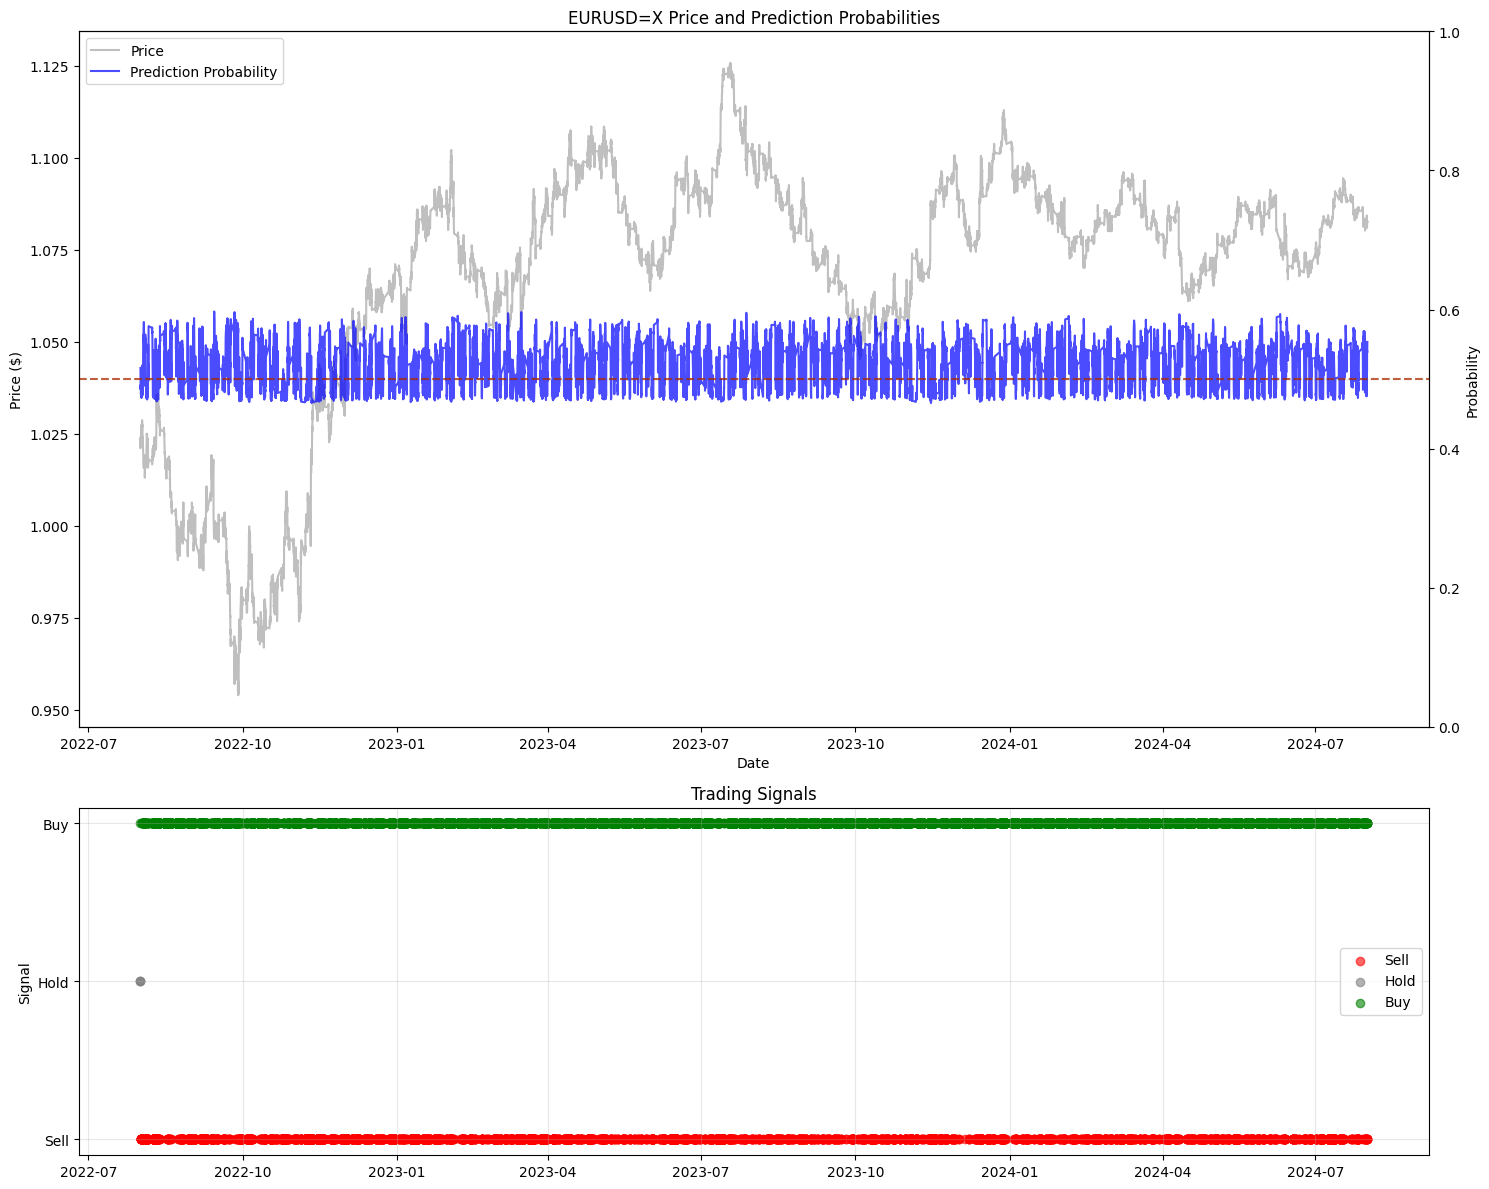

<Figure size 800x600 with 0 Axes>

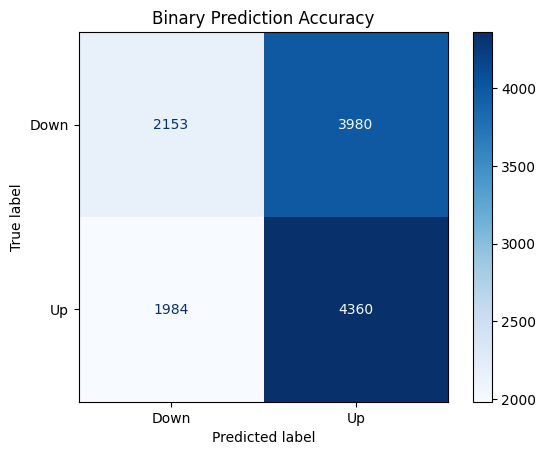


Binary Classification Report (probability > 0.5):
              precision    recall  f1-score   support

        Down       0.52      0.35      0.42      6133
          Up       0.52      0.69      0.59      6344

    accuracy                           0.52     12477
   macro avg       0.52      0.52      0.51     12477
weighted avg       0.52      0.52      0.51     12477


Trading Signal Distribution:
Buy: 8340 (66.8%)
Sell: 4137 (33.1%)
Hold: 3 (0.0%)

Debug info for Trading Period:
Number of rows: 12477
NaN counts in key columns:
position: 0 NaN values
actual_return: 0 NaN values
close: 0 NaN values

Trading Period Performance Metrics:
Date Range: 2022-08-01 to 2024-07-31
Number of Trading Hours: 12477

Return Metrics:
Total Return: -2.63%
Market Return: 5.93%
Annualized Return: -1.28%
Market Annualized Return: 2.83%
Sharpe Ratio: -0.40
Maximum Drawdown: 13.99%

Trading Metrics:
Number of Completed 'Round' Trades: 1461
Average Hourly Return (before costs): 0.0021%
Average Hourly R

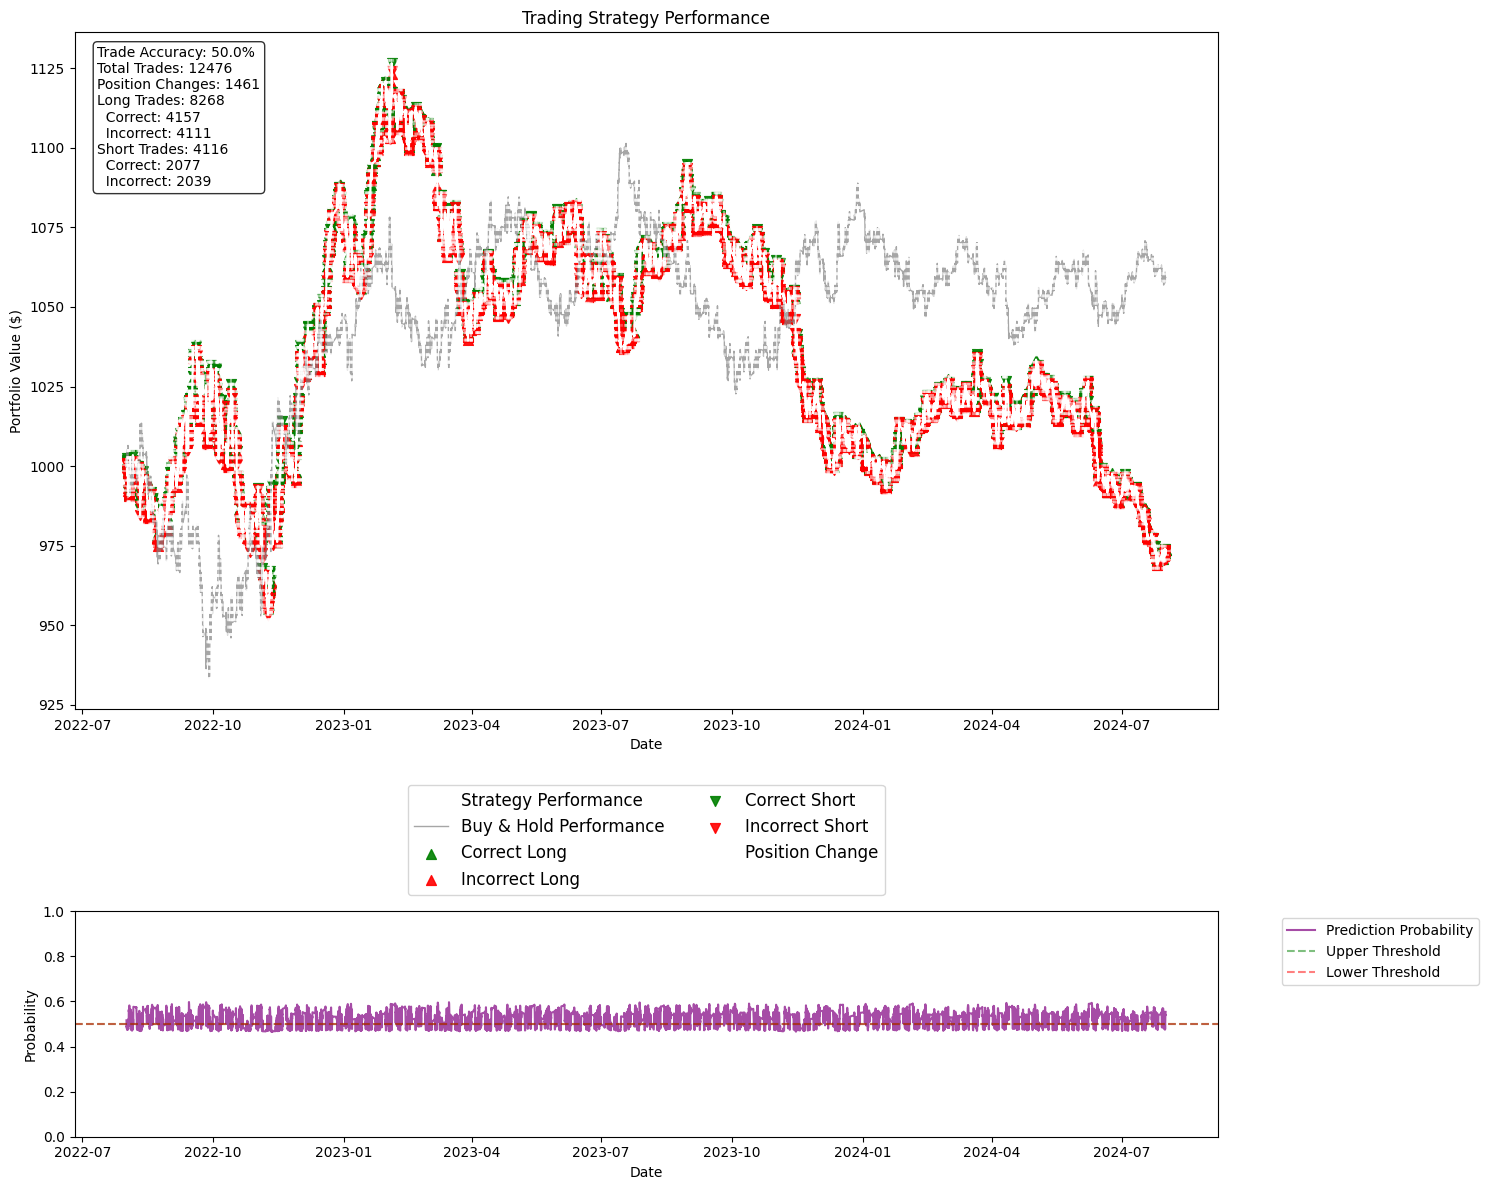

In [2]:
# 1. First, check the raw predictions from the model
test_ticker = 'EURUSD=X'
ticker_data = predictor.testing_data[predictor.testing_data['ticker'] == test_ticker].copy()

# Create sequences
X_test, y_test, _ = predictor.create_sequences(ticker_data, predictor.window_size, predictor.scaler)

# Get raw predictions
raw_predictions = predictor.model.predict(X_test)

for test_ticker in ['EURUSD=X']:  # Major forex pairs
    print(f"\nTesting model on {test_ticker}...")
    predictions = predictor.predict_forex(
        test_ticker,
        upper_threshold=0.50,
        lower_threshold=0.50
    )
    predictor.plot_results(predictions, test_ticker)
    results = predictor.evaluate_trading_strategy(
        predictions,
        initial_capital=1000,
        transaction_cost= 0.0001,  #5, #0.0001,  # To assess the model's ability to capture patterns on the original time-series without transaction costs involved. 
        ticker=test_ticker
    )